# Tarea 1 Redes Neuronales Artificiales - 2020-1 

## PREGUNTA 1

Integrantes: Andrea Freire - Francisco Sáez - Yeiniel Alfonso


## 1. Conceptos Básicos de redes neuronales

De las redes neuronales artificiales más simples se encuentran las redes densas o _Feed Forward_, donde todas las neuronas de una capa están conectadas a todas las salidas de la capa anterior y envían su señal de activación a todas las neuronas de la siguiente capa. Estas redes, si bien son las más simples, suelen tener desempeños bastante buenos, y en muchas aplicaciones reales son utilizadas, ya sea por si solas o en combinación con otros modelos. Además, son las redes donde más facil se pueden observar muchos de los fenómenos que se han descubierto a lo largo de los años de desarrollo de esta área del conocimiento, tanto por ser de las redes vigentes más antiguas y por su estructura relativamente simple. En esta primera parte de la tarea exploraremos las redes densas y algunos de sus hiperparámetros más relevantes como la profundidad, el número de unidades, learning rate, etc; estudiaremos también algunos métodos de regularización y evidenciaremos el problema del _vanishing gradient_ y el _exploding gradient_, viendo también algunos optimizadores existentes.

<h1 align='center'> <img src="https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/water-flea-daphnia-magna-ted-kinsman.jpg" width="40%" height="30%" /> </h1>

Para realizar esto usaremos un problema de regresión sencillo y utilizaremos los paquetes tensorflow y keras para explorar los conceptos básicos del mundo de las redes neuronales artificiales. Dado que puede tomar tiempo entrenar redes neuronales, y existe una amplia gama de conceptos a cubrir, utilizaremos un data set de tamaño limitado con menos de 1000 observaciones, recordar que las redes neuronales tienen una naturaleza _data hungry_ por lo que su desempeño se puede ver limitado por la poca cantidad de observaciones en algunos casos. El dataset en cuestión consiste en 8 atributos (descriptores moleculares) de 546 productos químicos usados para predecir la toxicidad acuática aguada hacia la especie Daphnia Magna, para su descarga y descripción mas detallada:  https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity.

### 1.a Carga de datos y preprocesamiento

In [ ]:
# Paquetes
import pandas as pd
import numpy as np
from google.colab import files 
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

I) Partiremos cargando los datos


In [ ]:
uploaded = files.upload()
header_list = ["TPSA","SAacc","H-050","MLOPG","RDCHI",
               "GATS1p","nN","C-050","LC50-response"]
df  = pd.read_csv(io.BytesIO(uploaded['qsar_aquatic_toxicity.csv']),
                  names = header_list, sep = ";")

Saving qsar_aquatic_toxicity.csv to qsar_aquatic_toxicity.csv


II) **Comente y visualice** las distribuciones de cada atributo del dataset utilizando herramientas estadísticas básicas, boxplots e histogramas.

In [ ]:
df.describe()

,TPSA,SAacc,H-050,MLOPG,RDCHI,GATS1p,nN,C-050,LC50-response
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,48.472930,58.869018,0.937729,2.313493,2.492299,1.046264,1.003663,0.353480,4.658421
std,46.763983,68.166554,1.618632,1.741797,0.811004,0.403677,1.397240,0.806827,1.665215
min,0.000000,0.000000,0.000000,-6.446000,1.000000,0.281000,0.000000,0.000000,0.122000
25%,15.790000,11.000000,0.000000,1.232500,1.975000,0.737000,0.000000,0.000000,3.601500
50%,40.460000,42.683000,0.000000,2.273500,2.344000,1.020500,1.000000,0.000000,4.516000
75%,70.022500,77.492750,1.000000,3.392750,2.911000,1.266500,2.000000,0.000000,5.607500
max,347.320000,571.952000,18.000000,9.148000,6.439000,2.500000,11.000000,11.000000,10.047000


**Comentario:** se puede apreciar que todas las columnas tienen media y desviación estandar de diferentes ordenes de magnitud, por lo que será necesario estandarizar esta data. Lo anterior es un paso clave a la hora de entrenar la red dado que afecta directamente en los pesos de la red.

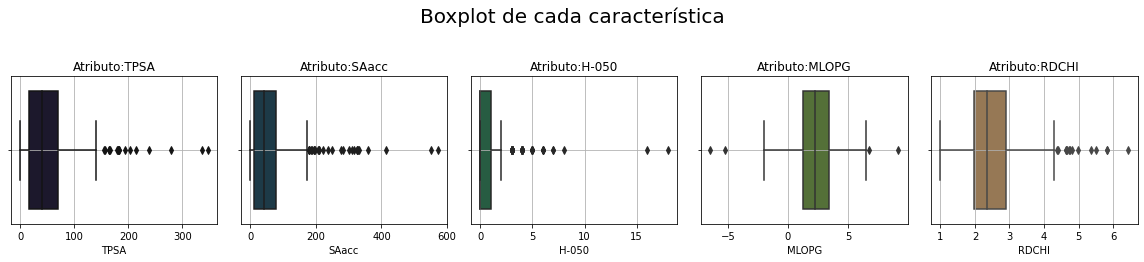

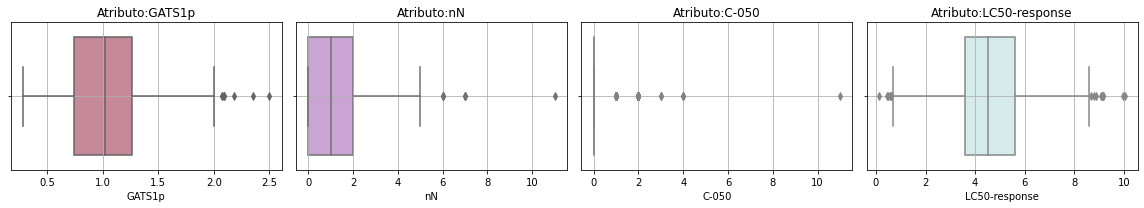

In [ ]:
plt.rcParams['figure.figsize'] = [16,3]
cols = sns.color_palette('cubehelix',9)
plt.suptitle('Boxplot de cada característica', size = 20, y = 1.2)
k, K = 1,1
for i in df.columns[:]:
  if K <= 5:
    plt.subplot(1,5,k)
  else: 
    plt.subplot(1,4,k)
  plt.title('Atributo:'+str(i))
  sns.boxplot(x=df[i], color = cols[K-1])
  plt.tight_layout()
  plt.grid()
  if k == 5:
    k = 1
    K += 1
    plt.show()
  else: 
    k += 1
    K += 1

**Comentarios:** gracias a este gráfico se puede ver que que los datos están a escala distintas y se puede apreciar que existe una gran cantidad de outliers en todos los atributos que se utilizarán, lo cual puede presentar un problema a la hora de entrenar la red.

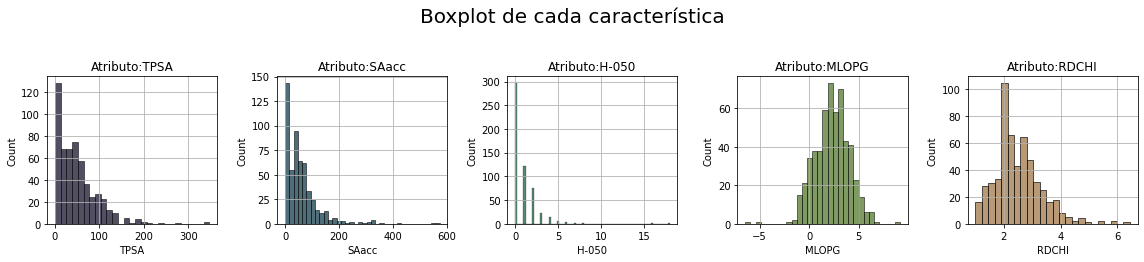

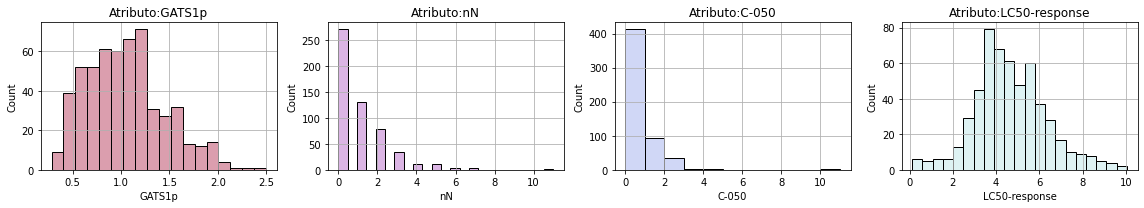

In [ ]:
plt.rcParams['figure.figsize'] = [16,3]
cols = sns.color_palette('cubehelix',9)
plt.suptitle('Histograma de cada característica', size = 20, y = 1.2)
k, K = 1,1
for i in df.columns[:]:
  if K <= 5:
    plt.subplot(1,5,k)
  else: 
    plt.subplot(1,4,k)
  plt.title('Atributo:'+''+str(i))
  sns.histplot(df[i], color = cols[K-1])
  plt.tight_layout()
  plt.grid()
  if k == 5:
    k = 1
    K += 1
    plt.show()
  else: 
    k += 1
    K += 1

**Comentario:** lo dicho anteriormente se puede comprobar con los gráficos expuestos, donde se ve que los atributos estan en diferentes escalas. Por otro lado se ve que hay atributos que estan más concentrados hacia valores pequeños y otros que tienen un comportamiento similar a una distribución normal.


III) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para luego estandarizar, considere un 70% de los datos para entrenamiento, un 20% para validación y un 10% para test. Para esto puede utilizar la librería sklearn, en particular las funciones StandarScaler y train_test_split. **Verifique** que el tamaño de los conjuntos se asemeja a lo indicado.

**Preguntas**: ¿Cuál es la función de cada uno de estos conjuntos?


**Conjuntos:**
* **Train set:** este conjunto es el que permite obtener los parámetros del modelo en el entrenamiento. Por ejemplo, mediante este conjunto se obtienen los pesos del modelo.
* **Validation set:** es un subconjunto del train set y es utilizado para obtener los hiperparámetros del modelo, por ejemplo, el learning rate. Una forma de obtener estos hiperparámetros es utilizar cross validation, donde se entrena el modelo con el train set y se testea con el validation set.
* **Test set:** este conjunto tiene la característica que no se utiliza en todo el proceso de ajustar el modelo, solo se utiliza cuando el modelo tiene los parámetros e hiperparámetros ajustados y en este conjunto se testea que tan bien generaliza el modelo.

In [ ]:
# Data
x = df.drop(columns = ['LC50-response'])
y = np.asarray(df['LC50-response']).reshape(-1,1)

# Separación de conjuntos
x_tr, x_tst, y_tr, y_tst = train_test_split(x,y,test_size =0.1, shuffle = True)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size = 0.2/0.9, shuffle = True)

In [ ]:
# Verificación
print('Train set:',np.round(len(x_tr)/len(x)*100,3),'\n')
print('Validation set:',np.round(len(x_val)/len(x)*100,3),'\n')
print('Test set:',np.round(len(x_tst)/len(x)*100,3))

Train set: 69.78 

Validation set: 20.147 

Test set: 10.073


**Comentario:** se puede comprobar que los datos fueron separado según lo que se indica en el enunciado.

In [ ]:
# Estandarización
scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaler_x.fit(x_tr)
scaler_y.fit(y_tr.reshape(-1,1))

# Transformación de conjuntos
x_tr  = scaler_x.transform(x_tr)
x_val = scaler_x.transform(x_val)
x_tst = scaler_x.transform(x_tst)

y_tr  = scaler_y.transform(y_tr)
y_val = scaler_y.transform(y_val)
y_tst = scaler_y.transform(y_tst)

IV) **Visualice** de la forma que estime conveniente para realizar comparaciones, las distribuciones para todas las variables (atributos y target) antes de estandarizar, y despues de estandarizar para los conjuntos de entrenamiento, validación y test. **Comente**

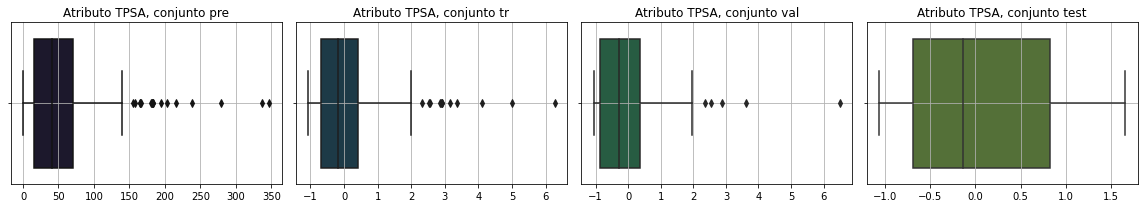

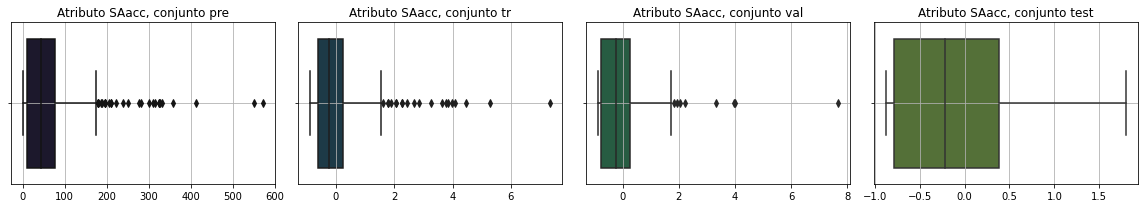

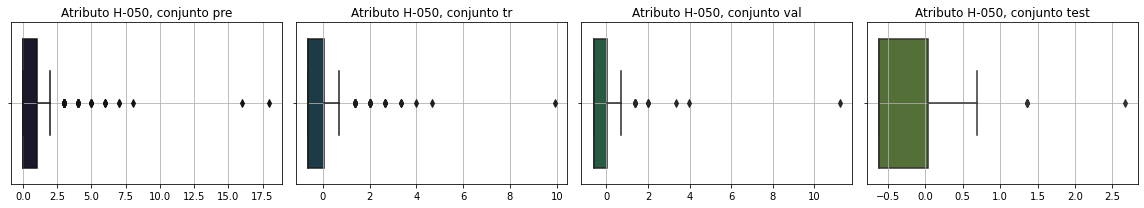

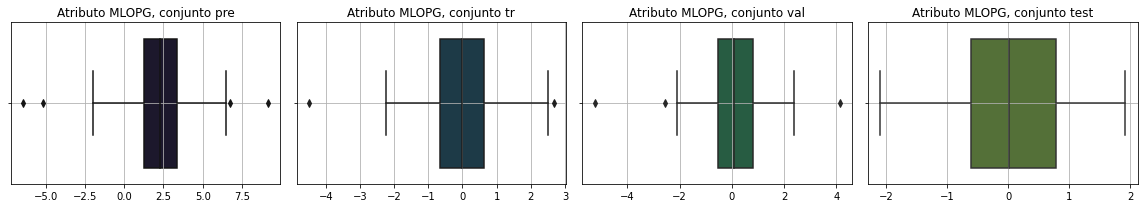

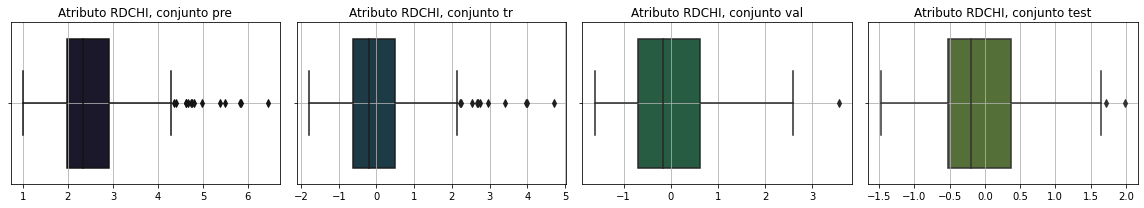

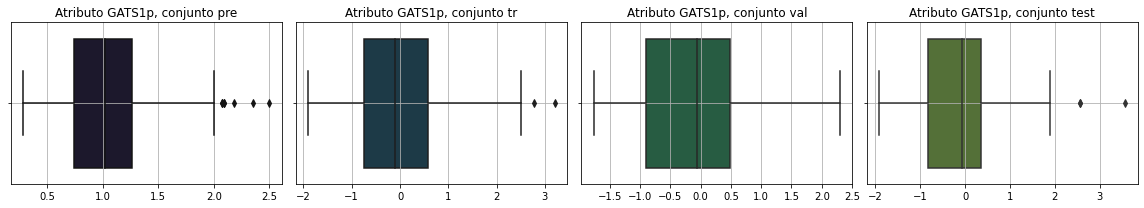

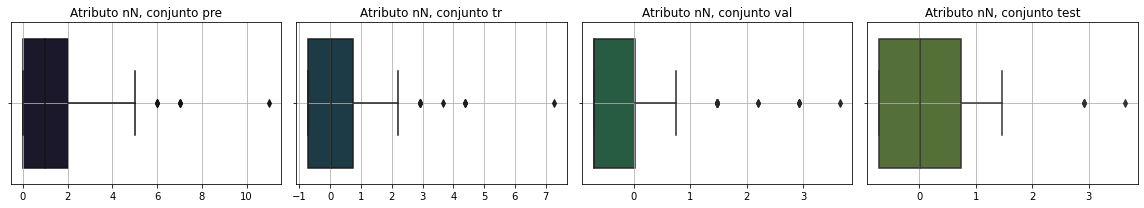

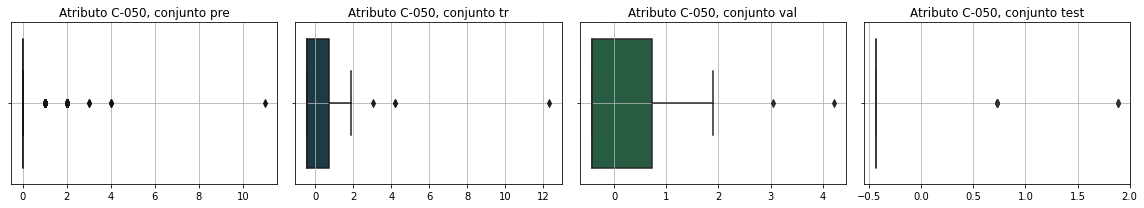

In [ ]:
name = ['pre','tr','val','test']
plt.rcParams['figure.figsize'] = [16,3]
for j in range(8): # <- completar
  vars=[np.asarray(x)[:,j],x_tr[:,j],x_val[:,j],x_tst[:,j]]
  for k in range(4):
    plt.subplot(1,4,k+1)
    plt.title('Atributo '+df.columns[j]+', conjunto '+ name[k]) # <- completar
    sns.boxplot(x=vars[k], color = cols[k]) # <- completar puede usar boxplot, histogramas u otra herramienta
    plt.tight_layout()
    plt.grid()
  plt.show()

**Comentarios:** se destaca que sin duda la estandarización de las variables ayuda en las escalas de los atributos, pero no a solucionar el problema de los outliers. 

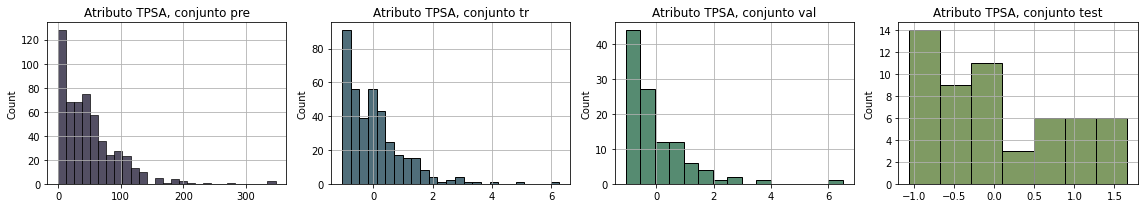

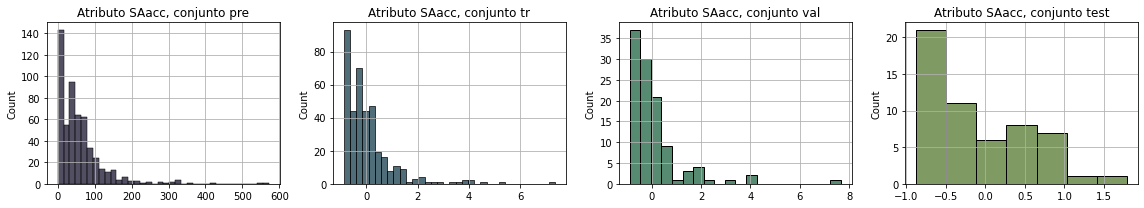

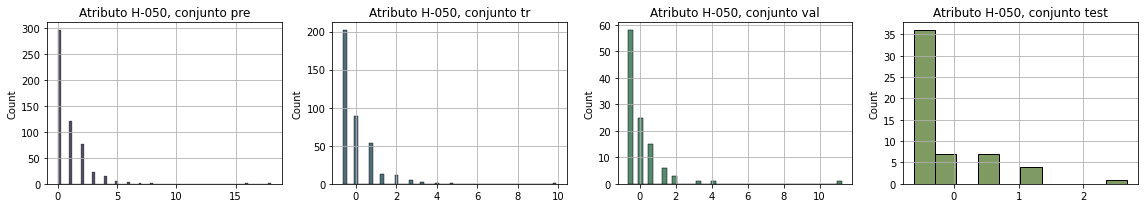

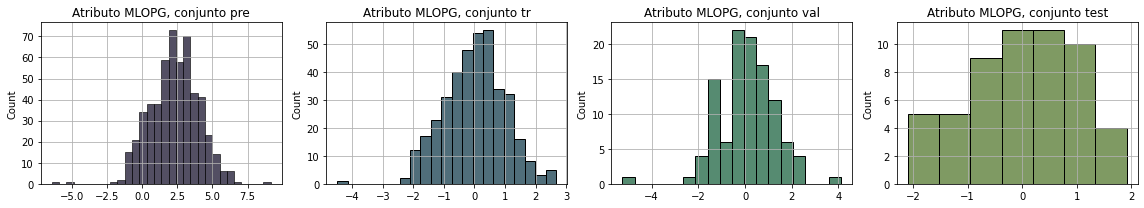

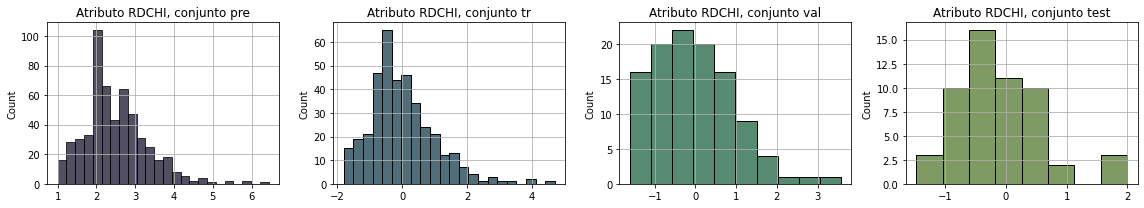

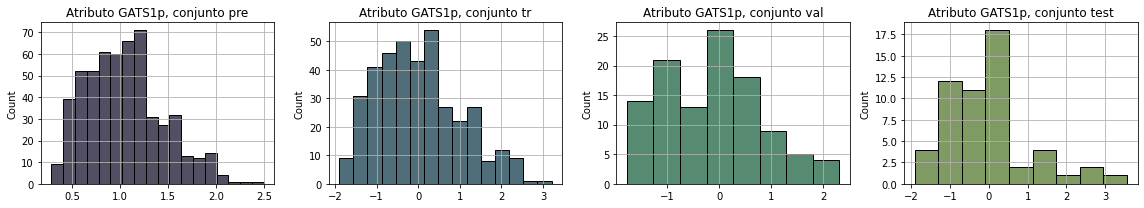

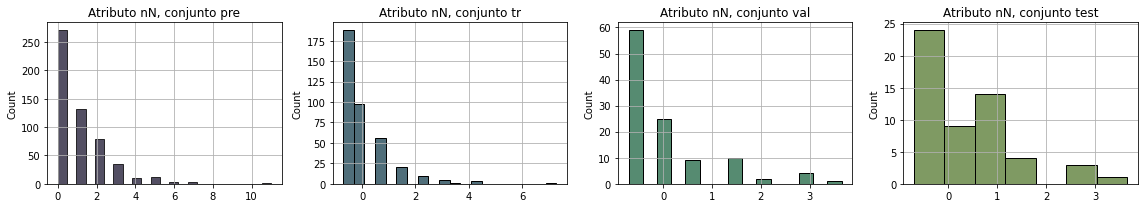

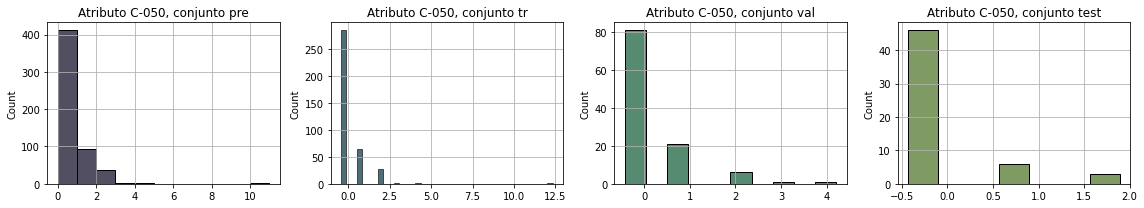

In [ ]:
name = ['pre','tr','val','test']
plt.rcParams['figure.figsize'] = [16,3]
for j in range(8): # <- completar
  vars=[np.asarray(x)[:,j],x_tr[:,j],x_val[:,j],x_tst[:,j]]
  for k in range(4):
    plt.subplot(1,4,k+1)
    plt.title('Atributo '+df.columns[j]+', conjunto '+ name[k]) # <- completar
    sns.histplot(vars[k],color=cols[k]) # <- completar puede usar boxplot, histogramas u otra herramienta
    plt.tight_layout()
    plt.grid()
  plt.show()

**Comentario:** en los gráficos anteriores se puede ver como afecta la estadarización de las variables en todos los atributos. Por ejemplo, en el primer atributo, estandarizar las variables disminuyo el rango de las variables maneteniendo la distribución.


V) **Pregunta:** ¿Por qué seleccionar los conjuntos de entrenamiento, validación y test _by hand_ es una mala práctica?¿Qué beneficios _tramposos_ se pueden obtener de esta mala práctica?

**Respuesta** si se seleccionan los atributos _by hand_ se elegir que los mejores ejemplos del dataset queden en el train set o en el test set lo que afectaría directamente en el desempeño del modelo, por ejemplo, se puede no dejar ningun outlier generando que se obtenga un menor error de generalización, siendo que el modelo en realidad no lo es.

VI) **Bonus** Tome decisiones, p.ej realice transformaciones, manipulaciones, etc... de manera fundamentada que ayuden a mejorar la conformación de los conjuntos para el posterior entrenamiento de la red neuronal. Evite malas prácticas.

- En este caso en particular no se recomendaría ningun cambio por la poca cantidad de datos. 
-Para el caso que se cuenten con más datos, se puede aplicar PCA para reducir el espacio de características lo cual es recomendable cuando un data set tiene una gran cantidad de atributos. 
- De la misma forma, se puede aplicar un kernel a la data para transformar de espacio y ver su compartamiento allí, por ejemplo, en el caso de ser linealmente separable. 
- Por último acotar que también se puede aplicar técnicas de oversampling en el caso que se cuenten con muchos datos.

### 1.b Primera arquitectura


Partiremos cargando los paquetes necesarios. Conozcamos tensorflow y keras: 

_TensorFlow_ es una librería de computación matemática, que ejecuta de forma rápida y efeciente gráficos de flujo. Un gráfico de flujo está formado por operaciones matemáticas representadas sobre nudos, y cuya entrada y salida es un vector multidimensional (o tensor) de datos. 

_Keras_ es una abstracción, un API High-level, para la creación de modelos de aprendizaje. Aporta una sintaxis homogénea y un interface sencillo, modular y ampliable para la creación de redes neuronales. 

Las redes neuronales son un tipo particular de gráfico de flujo de datos. Por tanto, TensorFlow y Keras combinan perfectamente.

In [ ]:
# Paquetes
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer
from keras.optimizers import SGD
from keras.callbacks import History
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

In [ ]:
# Arquitectura

input_dense  = input_layer.Input(shape=(x_tr.shape[1]))
dense        = layers.Dense(50, activation = 'sigmoid', use_bias = True)(input_dense)
output_dense = layers.Dense(1, activation = 'sigmoid', use_bias = True)(dense)
model        = models.Model(inputs = input_dense, outputs = output_dense)

# Compilación
model.compile(optimizer=SGD(learning_rate=0.01), loss = 'mean_squared_error')

# Callbacks
my_callbacks = [History(),
                tf.keras.callbacks.EarlyStopping(patience = 500, 
                                                 monitor = 'val_loss', restore_best_weights = True)]                                       

In [ ]:
# Train model
hist_1_b_i = model.fit(x_tr,y_tr, epochs = 500, verbose = 0, 
                       validation_data = (x_val,y_val), callbacks = my_callbacks)

Note cómo se puede evaluar todo el conjunto de test en sólo un paso:


In [ ]:
y_pred = model.predict(x_tst)
test_batch_loss = tf.keras.losses.MSE(y_tst,y_pred)

In [ ]:
print('Cantidad de datos del test set:', len(x_tst))

Cantidad de datos del test set: 55


Note cómo se obtiene el error MSE para cada observación en el conjunto de test. Se introdujo a propósito la notación batch para definir la variable python, esta dimensión debe ser siempre la primera dimensión del tensor cuando entrenamos redes neuronales. Un batch es un conjunto de observaciones, dado que estamos tratando con la evaluación del conjunto de test se utilizó un batch de tamaño máximo (igual a la cantidad de observaciones del conjunto de test).


In [ ]:
test_batch_loss

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([3.7467692e-02, 2.9495743e-01, 3.7404040e-01, 3.9144080e+00,
       2.5716765e+00, 1.2608466e+00, 2.5641993e-03, 2.4222310e-01,
       1.3242501e+00, 2.1307666e+00, 1.9897060e-03, 2.8185031e-01,
       1.9447992e+00, 1.4601539e-01, 1.8185748e-01, 6.2695205e-02,
       4.6455172e-01, 4.8010850e-01, 1.9318527e-02, 2.7905604e-01,
       3.3657222e+00, 1.3082516e-01, 1.5116616e-01, 2.0328064e-01,
       3.9925689e-01, 7.7968895e-02, 4.3830004e-01, 1.8115833e-01,
       1.1204479e+00, 3.9859653e+00, 7.5487926e-04, 1.8244489e-01,
       5.2625805e-01, 1.6465142e+00, 2.9445076e-01, 1.8508507e-01,
       6.4837146e-01, 4.7632235e-01, 1.2873389e-02, 4.2639365e+00,
       2.5587207e-02, 1.1210721e+00, 1.1726715e-02, 1.0163243e-04,
       4.7952563e-01, 5.6422472e-01, 4.4207838e-01, 2.0395868e-02,
       1.4504281e-01, 4.1032892e-01, 3.4628084e-01, 5.6615867e-02,
       6.8193383e+00, 1.0498766e+00, 8.1534376e-03], dtype=float32)>

Obtenga el error MSE promedio para todo el conjunto de test. **Aprecie** cómo se graficará el proceso de entrenamiento de la red neuronal, tendrá que repetir este proceso para reportar resultados múltiples veces durante el ramo. Utilice verbose = 1 para reportar resultados **NO ES VÁLIDO**, dado que es de díficil lectura y ocupa una cantidad de espacio innecesaria, se recomienda utilizar esta opción para estimar cuánto tiempo se demorará en entrenar la red viendo un par de epochs, luego se puede pausar el entrenamiento y desactivar el verbose para volver a entrenar. Esto no es obligatorio y condicional de cuánto epochs se están entrenando, sin embargo considere que un entrenamiento por 1000 epochs puede ocupar el equivalente a 10 páginas de pdfs, lo que dificultará la navegación por el archivo, pues no siempre es posible plegar el output de una celda (depende de cómo se está visualizando el archivo, p. ej al ver un notebook por github no se podrán plegar los outputs). **Comente** el gráfico generado.

**Preguntas**: ¿existe overfitting?¿Qué conclusiones puede sacar al observar el error del conjunto de test y compararlo respecto al conjunto de entrenamiento y validación?



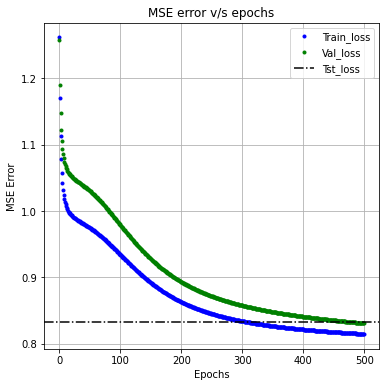

In [ ]:
plt.rcParams['figure.figsize'] = [6,6]
test_loss_1_b_i = tf.math.reduce_mean(test_batch_loss).numpy()                   # Calcula el promedio de test_batch_loss
plt.title('MSE error v/s epochs')
plt.plot(hist_1_b_i.history['loss'],'b.',label = 'Train_loss')
plt.plot(hist_1_b_i.history['val_loss'],'g.',label = 'Val_loss')
plt.axhline(y = test_loss_1_b_i, color= 'k', linestyle = '-.', label = 'Tst_loss')
plt.xlabel('Epochs'),plt.ylabel('MSE Error')
plt.legend(),plt.grid()
plt.show()

**Comentarios:** al entrenar la red con un dataset relativamente pequeño los resultados varian cada vez que se ajusta la red. En el gráfico se puede ver que para este caso, con las 500 epochs indicadas en el enunciado, el error de validación y entrenamiento continuan bajando lo que es indicio de que se debe seguir corriendo el modelo. Aún asi, se ve que los errores obtenidos son los esperados, es decir, el train es menor que el error de validación y se obtiene un error de test similar los anteriores.

Particularmente, del error de test se puede concluir que es muy variable respecto al entrenamiento producto de la poca cantidad de datos. Para el caso del gráfico se puede ver que es un error aceptable respecto al de validación y train, lo que implica que la predicción fue bastante buena considerando todo lo demás.

Para evitar reentrenar redes al reconectarse, la red neuronal entrenada se puede guardar (arquitectura, pesos y configuración de entrenamiento) del siguiente modo:


--> Para verificar que estamos guardando el modelo correctamente:  Iniciaremos clonando el modelo, esta función copia la arquitectura del modelo pero no mantiene los pesos.


In [ ]:
model_clone = tf.keras.models.clone_model(model)                   # Crea una copia del modelo
[np.all(model_clone.get_weights()[i]== model.get_weights()[i])  for i in range(len(model.get_weights()))]

[False, False, False, False]

--> Para esto setearemos los pesos del modelo clonado igual a los pesos del modelo original.

In [ ]:
model_clone.set_weights(model.get_weights())                # Ajusta los pesos del modelo a la copia
[np.all(model_clone.get_weights()[i]==model.get_weights()[i]) for i in range(len(model.get_weights()))]

[True, True, True, True]

--> Procederemos a guardar el modelo



In [ ]:
import sys
sys.path.append('saved_model')

In [ ]:
model.save('saved_model/1_b_i')

--> Verificamos

In [ ]:
model_new = tf.keras.models.load_model('saved_model/1_b_i/')
[np.all(model_clone.get_weights()[i]==model_new.get_weights()[i]) for i in range(len(model_new.get_weights()))] 

[True, True, True, True]

II) **Entrene** una red neuronal con los mismo hiperparámetros que en la sección anterior, pero con función de activación ReLU

In [ ]:
# Arquitectura
input_dense = input_layer.Input(shape=(x_tr.shape[1]))
dense       = layers.Dense(50, activation = 'relu', use_bias=True)(input_dense)
output_dense = layers.Dense(1, activation = 'relu', use_bias=True)(dense)
model = models.Model(inputs = input_dense, outputs = output_dense)

# Compilar
model.compile(optimizer=SGD(learning_rate=0.01), loss = 'mean_squared_error')
my_callbacks = [History(),
                tf.keras.callbacks.EarlyStopping(patience=500, monitor = 'val_loss',
                                                 restore_best_weights = True)]

hist_1_b_ii = model.fit(x_tr,y_tr, epochs=500, verbose = 0,
                        validation_data=(x_val,y_val), callbacks = my_callbacks)
test_loss_1_b_ii = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst,model(x_tst))).numpy()

III) **Cree** una función que grafique los resultados, puede basarse en el siguiente código. La función creada la puede ir modificando en lo siguientes itmes para reducir esfuerzos (fijarse en que la visualización sea lo más clara posible). **Visualice y compare** los resultados con los obtenidos en el punto 1.b.I). **Comente**

In [ ]:
# Variables
hists  = [hist_1_b_i.history,hist_1_b_ii.history]
tsts   = [test_loss_1_b_i,test_loss_1_b_ii]
titles = ['MSR error v/s epochs [sigmoid]','MSE error v/s epochs [ReLU]']

In [ ]:
# Función
def graph_results(hists,tsts,titles,size):
  k = 1
  plt.rcParams['figure.figsize'] = size
  fig, axes = plt.subplots(len(hists),1 , sharey=True)

  if len(hists) == 1:
    axes.set_title(titles[0])
    axes.plot(hists[0]['loss'],'b.',label = 'Train_loss')
    axes.plot(hists[0]['val_loss'],'g.', label = 'Val_loss')
    axes.axhline(y=tsts[0],color = 'k', linestyle = '-.', label = 'Tst_loss')
    axes.set_xlabel('Epochs')
    axes.set_ylabel('MSE Error')
    axes.legend()
    axes.grid()
  else:
    for i, ax in enumerate(axes):
      ax.set_title(titles[i])
      ax.plot(hists[i]['loss'],'b.',label = 'Train_loss')
      ax.plot(hists[i]['val_loss'],'g.', label = 'Val_loss')
      ax.axhline(y=tsts[i],color = 'k', linestyle = '-.', label = 'Tst_loss')
      ax.set_xlabel('Epochs')
      ax.set_ylabel('MSE Error')
    
      if i == len(axes)-1:
        ax.legend()
      ax.grid()
  plt.tight_layout()
  plt.show()

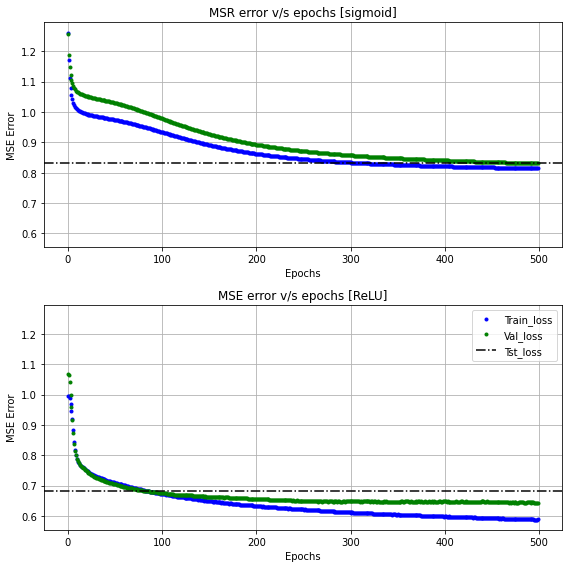

In [ ]:
graph_results(hists, tsts,titles, [8,8])

**Comentarios:** Se puede observar que el comportamiento de los gráficos es relativamente similar, pero se puede ver que para la función de activación ReLU la diferencia entre los errores en la epochs 500 es menor que para la función sigmoid. Esto se puede deber a que la función ReLU activa solo algunas neuronas a diferencia de la sigmoid que funciona con todas las neuronas.

Además, se puede ver que para las 500 epochs, las pérdidas de la red entrenada con sigmoid puede continuar bajando si se aumentan las epochs dado que el error de validación no ha aumentado. Por su parte, la red entrenada con la función relu, se puede ver que el error de validación se despega del error de train a partir de la epochs 200, de lo que se puede concluir que el entrenamiento si ha términado.

Respecto al error de entrenamiento, se puede ver que en el gráfico con la función sigmoid, este error está más cerca de los errores de train y validación. Para el caso de la red con la función relu, esta diferencia aumenta, pero esto se puede explicar por el mismo tema de las epochs para cada modelo.

## 1.c Sensibilidad a hiperparámetros

I) **Utilice** la siguiente función (o implemente la propia) para recopilar el error de entrenamiento, validación y test **según** el número de capas en la red neuronal y el número de neuronas. Considere el mismo número de neuronas para cada capa. Seleccione dos valores para la cantidad de neuronas entre 10 y 100, y varíe la profundidad entre 1 y 3, es decir, 6 redes en total. Utilice la función de activación ReLU, 500 epochs, lr=0.01 y error MSE.

**Encuentre los hiperparámetros (n° neuronas y profundidad) que obtienen el menor error de validación**

**Pregunta: ¿Por qué el menor error de validación y no de test?**

**Visualice y comente** los resultados

In [ ]:
def train_network_1_c_i(prof_dense, n_neurons):
  input_dense = input_layer.Input(shape=(x_tr.shape[1]))

  for i in range(prof_dense):
    # Si i = 0, se crea la primera capa, si no corresponde las siguientes capas.
    if i ==0:
      dense = layers.Dense(n_neurons, activation = 'relu', use_bias = True)(input_dense)
    else:
      dense = layers.Dense(n_neurons, activation = 'relu', use_bias = True)(dense)
  
  output_dense = layers.Dense(1, activation='relu', use_bias=True)(dense)
  model        = models.Model(inputs = input_dense, outputs = output_dense)

  # Compilación
  model.compile(optimizer = SGD(learning_rate=0.01), loss = 'mean_squared_error')

  my_callbacks = [History(),
                  tf.keras.callbacks.EarlyStopping(patience=100, monitor = 'val_loss',
                                                   restore_best_weights = True)]
  #Train model
  hist = model.fit(x_tr,y_tr,epochs=500, verbose=0, 
                   validation_data = (x_val,y_val), callbacks = my_callbacks)
  test_loss = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst,model(x_tst))).numpy()
  return (hist,test_loss)

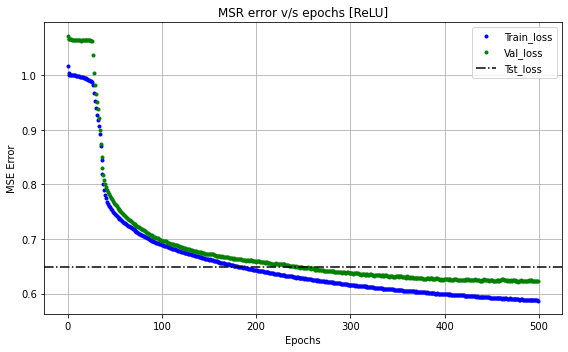

In [ ]:
h1,t1 = train_network_1_c_i(1,100)
min_val_loss_1 = np.min(h1.history['val_loss'])
graph_results([h1.history],[t1],['MSR error v/s epochs [ReLU]'],[8,5])

In [ ]:
prof_dense     = [1,2,3]
n_neurons      = [50,100]
resultados_p_n = []
error_val      = float('inf')

for i in prof_dense: 
  for j in n_neurons:
    h1,t1 = train_network_1_c_i(i,j)
    error = np.min(h1.history['val_loss'])
    if error < error_val:
      prof_val  = i
      neu_val   = j
      error_val = error
    resultados_p_n.append([i,j,h1.history,t1])

In [ ]:
print('El menor error de validación es: ', np.round(error_val,3),'para una profundidad de: ',prof_val,' y con: ', neu_val)

El menor error de validación es:  0.604 para una profundidad de:  3  y con:  100


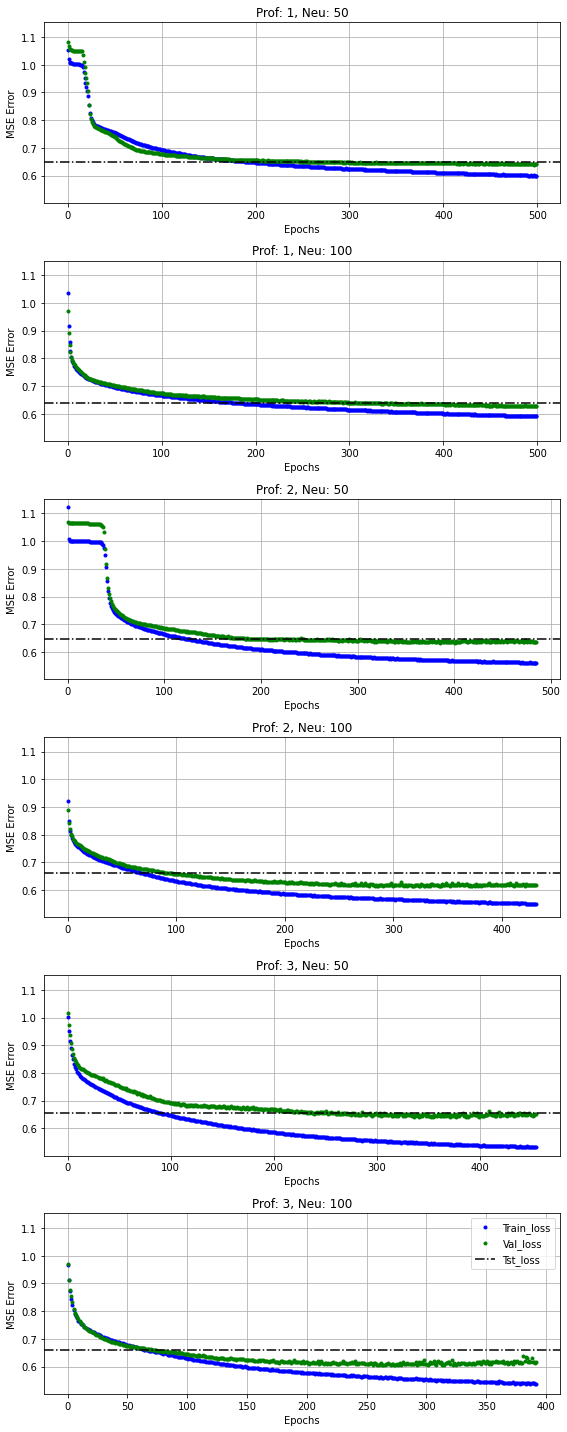

In [ ]:
hists_1_c_i  = []
t1_1_c_i     = []
titles_1_c_i = ['Prof: 1, Neu: 50','Prof: 1, Neu: 100','Prof: 2, Neu: 50','Prof: 2, Neu: 100','Prof: 3, Neu: 50','Prof: 3, Neu: 100']
for i in range(6): hists_1_c_i.append(resultados_p_n[i][2]), t1_1_c_i.append(resultados_p_n[i][3])
graph_results(hists_1_c_i,t1_1_c_i,titles_1_c_i,[8,20])

**Comentarios:** en el gráfico se puede comprobar que a mayor profundidad se obtienen mejores resultados para este caso en cuestión y al igual que con mayor cantidad de neuronas. Esto se debe a que la red puede extraer mayor información de la data y hacer más combinaciones lo que generar una mejor predicción. Por lo tanto, es esperable que el mejor valor de hiperparámetros sea mayor profundidad y mayor número de neuronas.

Para el cálculo de los hiperparámetros se utiliza el conjunto de validación y no de test, dado que el conjunto de test no se puede utilizar durante el entrenamiento de la red, entonces el conjunto de validación permite probar el modelo en un conjunto diferente con el cual fue entrenado. El conjunto de test solo te utiliza una vez que se tiene el modelo totalmente calibrado para ver la capacidad de generalización de este.

II) **Realice** un experimento similar, ahora variando el learning rate entre [1e-6 y 1e-1], es decir 6 redes neuronales con distinto learning rate. Para esto **implemente una función** semejante a la utilizada en el punto anterior, use la arquitectura e hiperparámetros dados. **Encuentre el learning rate que obtiene el menor error de visualización. Visualizar y comentar**

In [ ]:
def train_network_1_c_ii(l_rate):
  input_dense = input_layer.Input(shape=(x_tr.shape[1]))

  dense        = layers.Dense(50, activation='relu', use_bias=True)(input_dense)
  dense        = layers.Dense(50, activation='relu', use_bias=True)(dense)
  output_dense = layers.Dense(1, activation='relu', use_bias=True)(dense)
  model        = models.Model(inputs = input_dense, outputs = output_dense)

  # Compilación
  model.compile(optimizer = SGD(learning_rate=l_rate), loss = 'mean_squared_error')

  my_callbacks = [History(),
                  tf.keras.callbacks.EarlyStopping(patience=100, monitor = 'val_loss',
                                                   restore_best_weights = True)]
  #Train model
  hist = model.fit(x_tr,y_tr,epochs=500, verbose=0, 
                   validation_data = (x_val,y_val), callbacks = my_callbacks)
  test_loss = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst,model(x_tst))).numpy()
  return (hist,test_loss)

In [ ]:
l_rate          = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
resultados_rate = []
error_val       = float('inf')

for j in l_rate:
  h1,t1 = train_network_1_c_ii(j)
  error = np.min(h1.history['val_loss'])
  if error < error_val:
    lr = j
    error_val = error
  resultados_rate.append([j,h1.history,t1])

In [ ]:
print('El menor error de validación es: ', error_val,'para un learning rate de: ',lr)

El menor error de validación es:  0.6313193440437317 para un learning rate de:  0.1


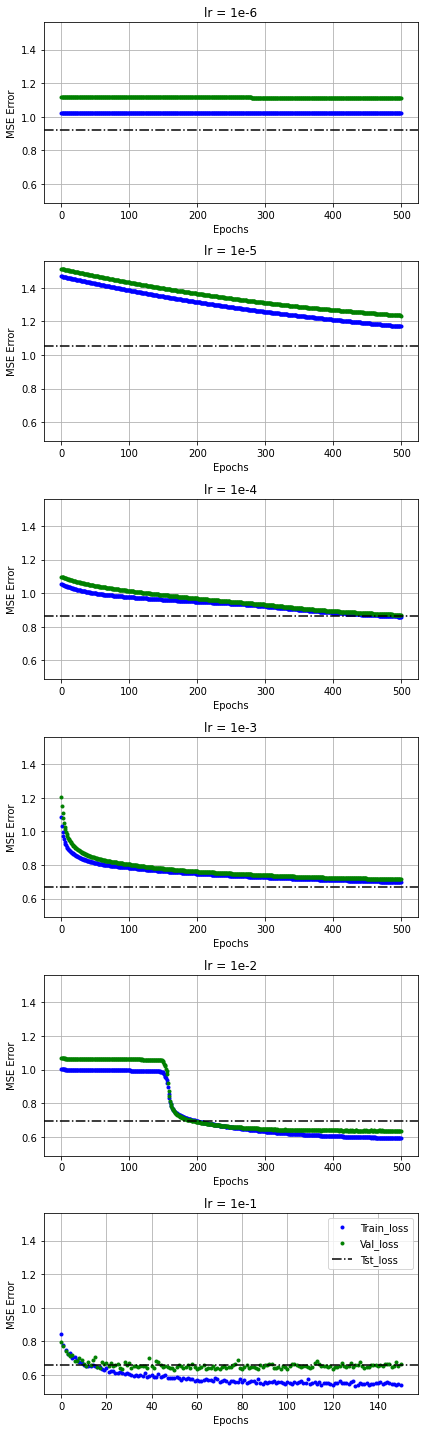

In [ ]:
hists_1_c_ii  = []
t1_1_c_ii     = []
titles_1_c_ii = ['lr = 1e-6','lr = 1e-5','lr = 1e-4','lr = 1e-3','lr = 1e-2','lr = 1e-1']
for i in range(6): hists_1_c_ii.append(resultados_rate[i][1]), t1_1_c_ii.append(resultados_rate[i][2])
graph_results(hists_1_c_ii,t1_1_c_ii,titles_1_c_ii,[6,20])

**Comentarios:** en general se obtiene que el modelo converge más lento con un learning rate mas pequeño, se necesitan más epochs para poder obtener los mismos valores de convergencia.  Entonces, para un learning rate muy pequeño, como es el caso de 1e-6 se puede ver que con las 500 epochs no es suficiente para obtener un valor de pérdida aceptable. Caso contrario es el otro extremo, donde se puede ver que un learning rate de 1e-1, este converge mucho más rapido, incluso se activo el early stopping para detener el entrenamiento. 

III) **Realice** un experimento similar, ahora variando el learning decay, entrene 6 redes neuronales para distintos decay. Para esto **implemente una función** semejante a la utilizada en el punto anterior. **Encuentre el learning decay que obtiene el menor error de validación. Visualiar y comentar**

In [ ]:
def train_network_1_c_iii(lear_decay):
  input_dense = input_layer.Input(shape=(x_tr.shape[1]))

  dense        = layers.Dense(50, activation='relu', use_bias=True)(input_dense)
  dense        = layers.Dense(50, activation='relu', use_bias=True)(dense)
  output_dense = layers.Dense(1, activation='relu', use_bias=True)(dense)
  model        = models.Model(inputs = input_dense, outputs = output_dense)

  # Compilación
  model.compile(optimizer = SGD(learning_rate=0.01, decay= lear_decay), loss = 'mean_squared_error')

  my_callbacks = [History(),
                  tf.keras.callbacks.EarlyStopping(patience=200, monitor = 'val_loss',
                                                   restore_best_weights = True)]
  #Train model
  hist = model.fit(x_tr,y_tr,epochs=500, verbose=0, 
                   validation_data = (x_val,y_val), callbacks = my_callbacks)
  test_loss = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst,model(x_tst))).numpy()
  return (hist,test_loss)

In [ ]:
lear_decay       = np.around(np.logspace(-6,0,6),decimals=6)
resultados_decay = []
error_val        = float('inf')

for j in lear_decay:
  h1,t1 = train_network_1_c_iii(j)
  error = np.min(h1.history['val_loss'])
  if error < error_val:
    decay = j
    error_val = error
  resultados_decay.append([j,h1.history,t1])

In [ ]:
print('El menor error de validación es: ', error_val,'para un decay de: ',decay)

El menor error de validación es:  0.6039219498634338 para un decay de:  0.000251


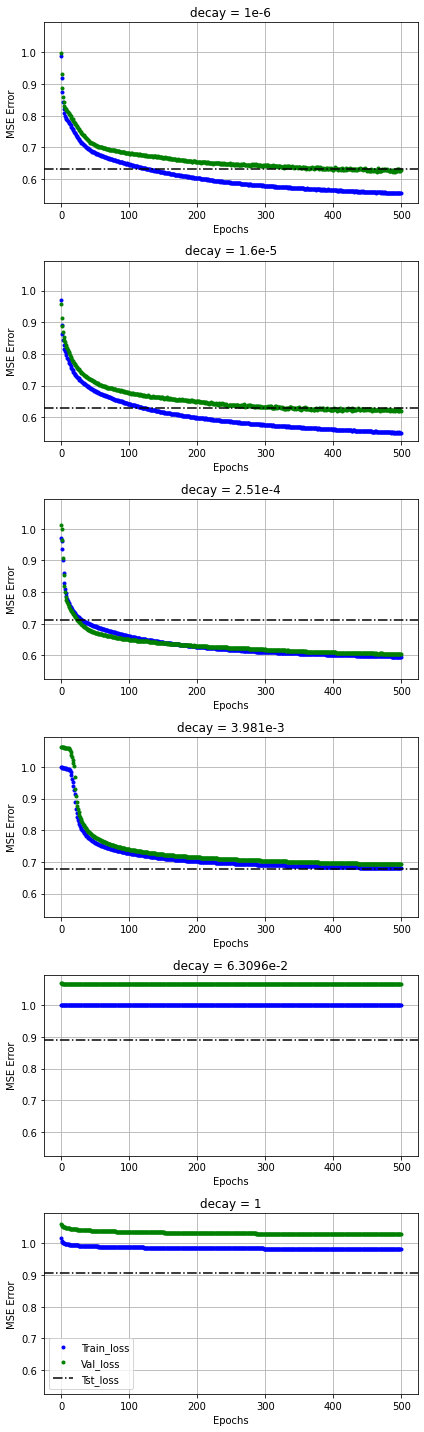

In [ ]:
hists_1_c_iii  = []
t1_1_c_iii     = []
titles_1_c_iii = ['decay = 1e-6','decay = 1.6e-5','decay = 2.51e-4','decay = 3.981e-3','decay = 6.3096e-2','decay = 1']
for i in range(6): hists_1_c_iii.append(resultados_decay[i][1]), t1_1_c_iii.append(resultados_decay[i][2])
graph_results(hists_1_c_iii,t1_1_c_iii,titles_1_c_iii,[6,20])

**Comentarios:** en este caso, para un decay muy pequeño se obtiene un entrenamiento muy similar al caso sin decay por razones de ordenes de magnitud. Por lo tanto, el decay óptimo en este caso corresponde a un valor intermedio en el rango que se esta explorando, donde se ve que la ayuda a mejorar el entrenamiento obteniendo valores de de error esperables respecto a los casos anteriores.

IV) **Realice** un experimento similar, ahora variando el optimizador para la arquitectura e hiperparámetros dados, pruebe con los optimizadores [SGD, Adagrad,Adadelta,Adam y RMSprop]. Para esto **implemente una función** semejante a la utilizada en el punto anterior. **Pregunta**: ¿ En qué optimizadores no tiene sentido utilizar el learning decay, Por qué? **Visualizar y comentar**

In [ ]:
def train_network_1_c_iv(opti):
  input_dense = input_layer.Input(shape=(x_tr.shape[1]))

  dense        = layers.Dense(50, activation='relu', use_bias=True)(input_dense)
  dense        = layers.Dense(50, activation='relu', use_bias=True)(dense)
  output_dense = layers.Dense(1, activation='relu', use_bias=True)(dense)
  model        = models.Model(inputs = input_dense, outputs = output_dense)

  # Compilación
  model.compile(optimizer =opti(learning_rate=0.01), loss = 'mean_squared_error')

  my_callbacks = [History(),
                  tf.keras.callbacks.EarlyStopping(patience=500, monitor = 'val_loss',
                                                   restore_best_weights = True)]
  #Train model
  hist = model.fit(x_tr,y_tr,epochs=500, verbose=0, 
                   validation_data = (x_val,y_val), callbacks = my_callbacks)
  test_loss = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst,model(x_tst))).numpy()
  return (hist,test_loss)

In [ ]:
opti            = [SGD,Adam,RMSprop,Adagrad,Adadelta]
resultados_opti = []
error_val       = float('inf')
for j in opti:
  h1,t1 = train_network_1_c_iv(j)
  error = np.min(h1.history['val_loss'])
  if error < error_val:
    optimi = j
    error_val = error
  resultados_opti.append([j,h1.history,t1])

In [ ]:
print('El menor error de validación es: ', error_val,'para un optimizador: ',str(optimi))

El menor error de validación es:  0.5841196179389954 para un optimizador:  <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>


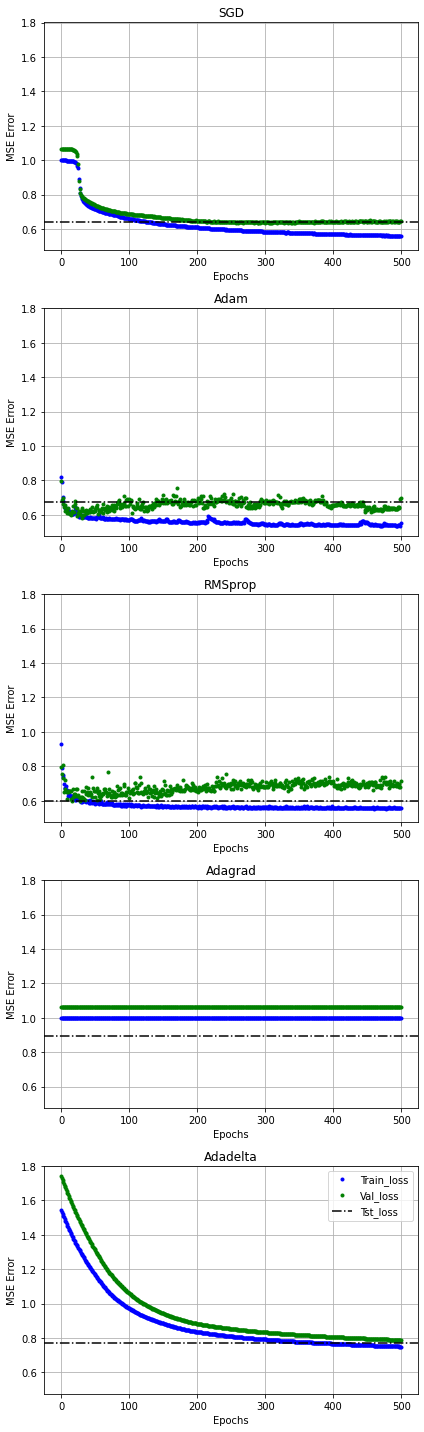

In [ ]:
hists_1_c_iv  = []
t1_1_c_iv     = []
titles_1_c_iv = ['SGD','Adam','RMSprop','Adagrad','Adadelta']
for i in range(5): hists_1_c_iv.append(resultados_opti[i][1]), t1_1_c_iv.append(resultados_opti[i][2])
graph_results(hists_1_c_iv,t1_1_c_iv,titles_1_c_iv,[6,20])

**Comentarios:** se puede ver que para un mismo learning rate, cada optimizador actua de forma diferente, siendo adam el mejor respecto al error que se obtiene en el conjunto de validación. Incluso se puede ver que para el optimizador Adagrad no se presentan variaciones en las epochs lo que se puede deber directamente al learning rate.

V) **Realice** un experimento similar, ahora variando el batch_size entre 1 y x_tr.shape[0] incluyendo los extremos. Entrene 6 redes neuronales con la arquitectura e hiperparámetros dados. Para esto implemente una función semejante a la utilizada en el punto anterior. Para un batch_size=1 el entrenamiento se va a demorar más que en puntos aponteriores, aprox 1 segundo en _Colab_. **Visualizar y comentar. Preguntas**¿A qué es equivalente entrenar con un batch_size =1 y batch_size = x_tr.shape[0]?¿Cuál es el batch_size por default?

In [ ]:
def train_network_1_c_v(batch):
  input_dense = input_layer.Input(shape=(x_tr.shape[1]))

  dense        = layers.Dense(50, activation='relu', use_bias=True)(input_dense)
  dense        = layers.Dense(50, activation='relu', use_bias=True)(dense)
  output_dense = layers.Dense(1, activation='relu', use_bias=True)(dense)
  model        = models.Model(inputs = input_dense, outputs = output_dense)

  # Compilación
  model.compile(optimizer=Adam(learning_rate=0.001), loss = 'mean_squared_error')

  my_callbacks = [History(),
                  tf.keras.callbacks.EarlyStopping(patience=500, monitor = 'val_loss',
                                                   restore_best_weights = True)]
  #Train model
  hist = model.fit(x_tr,y_tr,epochs=500, verbose=0,batch_size=batch, 
                   validation_data = (x_val,y_val), callbacks = my_callbacks)
  test_loss = tf.math.reduce_mean(tf.keras.losses.MSE(y_tst,model(x_tst))).numpy()
  return (hist,test_loss)

In [ ]:
batches          = np.int32(np.round(np.linspace(1,x_tr.shape[0],6)))
resultados_batch = []
error_val        = float('inf')

for j in batches:
  h1,t1 = train_network_1_c_v(j)
  error = np.min(h1.history['val_loss'])
  if error < error_val:
    batch = j
    error_val = error
  resultados_batch.append([j,h1.history,t1])

In [ ]:
print('El menor error de validación es: ', error_val,'para un batch de: ',batch)

El menor error de validación es:  0.6260083913803101 para un batch de:  1


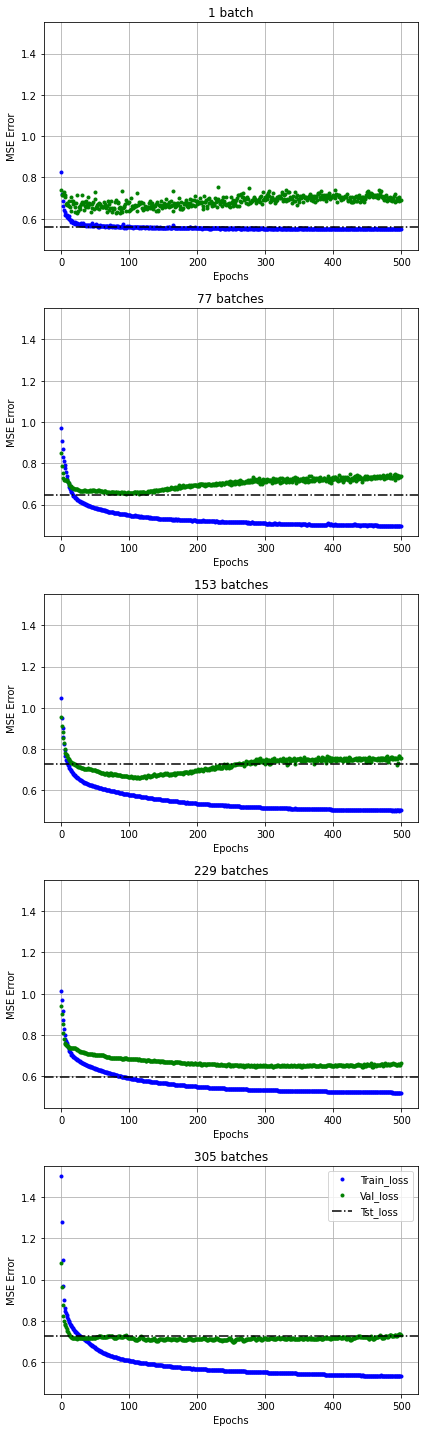

In [ ]:
hists_1_c_v  = []
t1_1_c_v     = []
titles_1_c_v = ['1 batch','77 batches','153 batches','229 batches','305 batches','381 batches']
for i in range(5): hists_1_c_v.append(resultados_batch[i][1]), t1_1_c_v.append(resultados_batch[i][2])
graph_results(hists_1_c_v,t1_1_c_v,titles_1_c_v,[6,20])

**Comentarios:** entrenar el modelo con un batch size de 1 equivale a utilizar gradiente descendiente estocástico clásico, donde se toma al azar un ejemplo del train set y se ajustan los pesos respecto a ese ejemplo. Por su parte si se tiene un batch size equivalente al número total de muestras, es igual a utilizar gradiente descendente clásico. El batch size por default corresponde 32 ejemplos.

Respecto a los resultados que se pueden apreciar en los gráficos, se ve que el menor error de validación se obtuvo para un batch size de tamaño 1, donde este modelo es equivalente a utilizar el gradiente descendente estocástico clásico. Una de las razones de esto, puede estar en el ejemplo utilizando en el entrenamiento no haya sido un outliers, por lo que la red si pudo aprender lo necesario para tener una buena predicción.

## 1.d Inicialización, pesos y gradientes

I) Utilizando las siguientes arquitecturas proceda a graficar la distribución de pesos de las distintas capas bajo inicialización uniforme (incluyendo bias). Adicionalmente calcule el gradiente de la función de pérdida (loss) para el conjunto de entrenamiento (promedio del gradiente del error de todos los datos de entrenamientos) respecto a los pesos de las distintas capas. **Visualize, compare y comente**

In [ ]:
# Define arquitectura (1)
input_dense = input_layer.Input(shape=(8))
dense = layers.Dense(100, activation = 'tanh', use_bias = True, kernel_initializer = 'uniform')(input_dense)
dense = layers.Dense(100, activation = 'tanh', use_bias = True, kernel_initializer = 'uniform')(dense)
dense = layers.Dense(100, activation = 'tanh', use_bias = True, kernel_initializer = 'uniform')(dense)
dense = layers.Dense(100, activation = 'tanh', use_bias = True, kernel_initializer = 'uniform')(dense)
output_dense = layers.Dense(1, activation = 'tanh', use_bias=True, kernel_initializer='uniform')(dense)
model = models.Model(inputs= input_dense, outputs = output_dense)

In [ ]:
# To understand where are the weights and number of weights:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               900       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 31,301
Trainable params: 31,301
Non-trainable params: 0
__________________________________________________

In [ ]:
# Get weights
weights = model.get_weights()
# Get gradient
with tf.GradientTape() as tape:
  y_pred = model(x_tr)
  loss   = tf.reduce_mean(tf.square(y_pred-y_tr))
  grad   = tape.gradient(loss, model.trainable_weights)

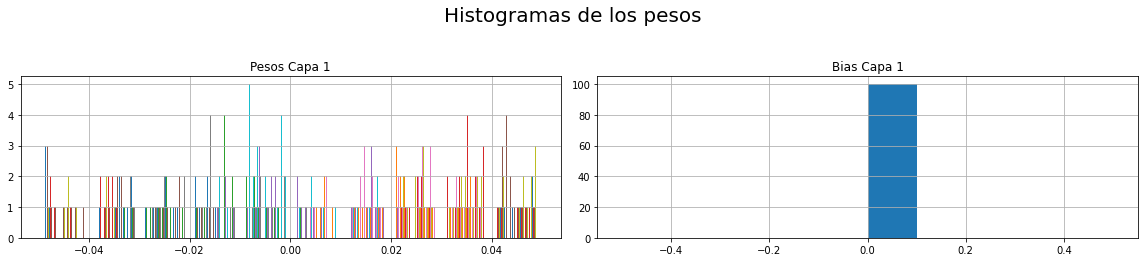

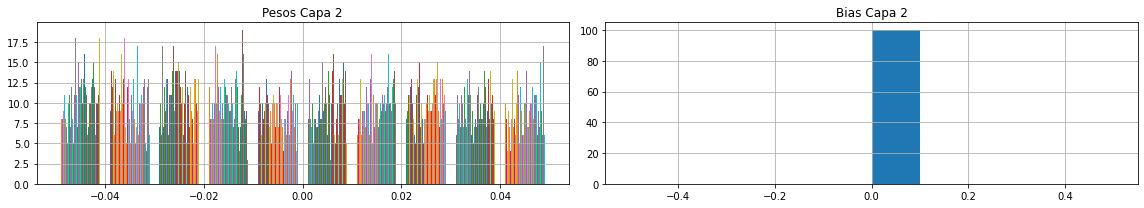

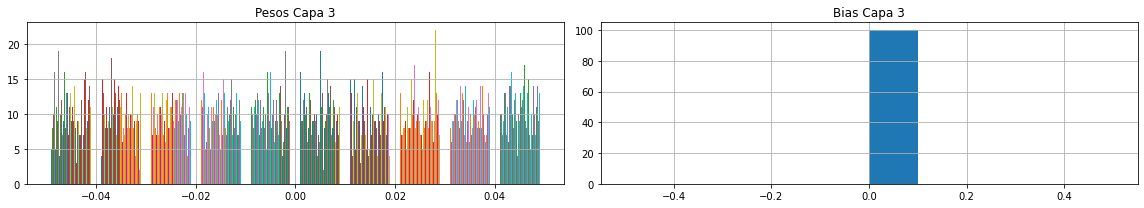

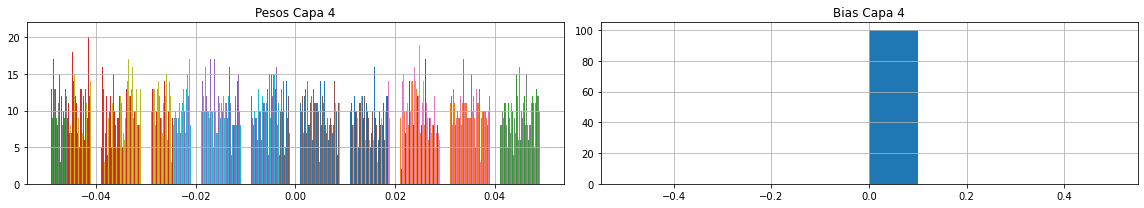

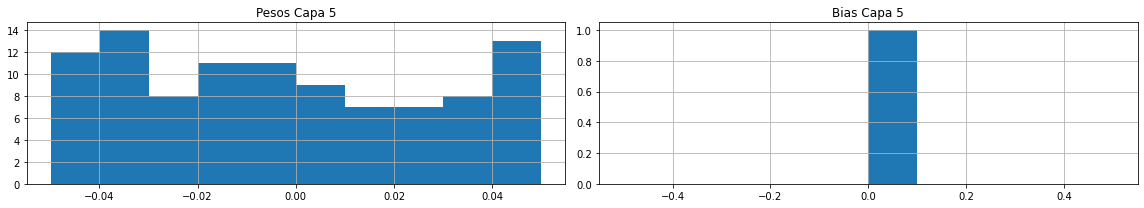

In [ ]:
plt.rcParams['figure.figsize'] = [16,3]
plt.suptitle('Histogramas de los pesos', size = 20, y = 1.2)
names = ['Pesos Capa 1', 'Bias Capa 1','Pesos Capa 2', 'Bias Capa 2','Pesos Capa 3', 'Bias Capa 3','Pesos Capa 4', 'Bias Capa 4','Pesos Capa 5', 'Bias Capa 5']
k = 1
for i in range(len(weights)):
  plt.subplot(1,2,k)
  plt.title(names[i])
  plt.hist(weights[i])
  plt.tight_layout()
  plt.grid()
  if k == 2:
    k = 1
    plt.show()
  else: 
    k += 1

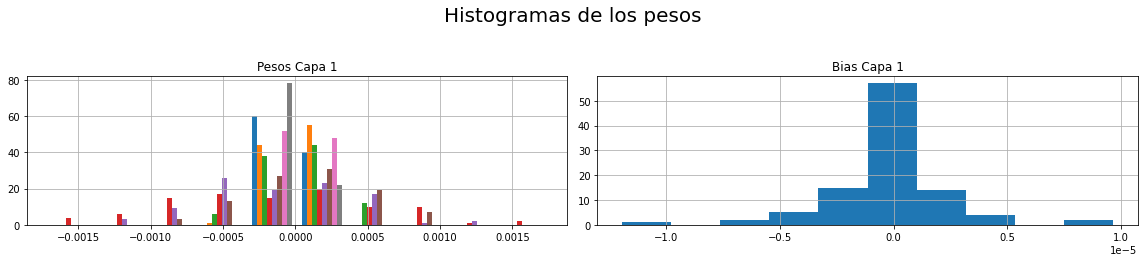

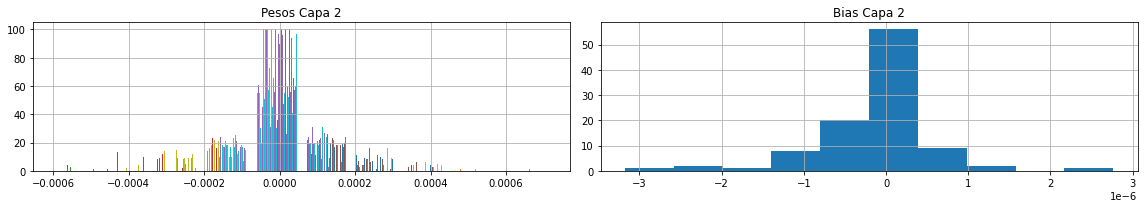

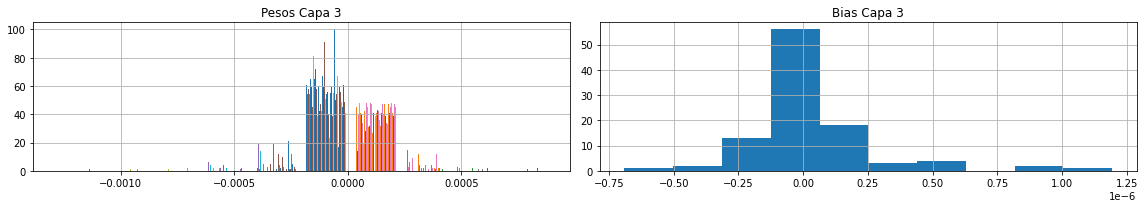

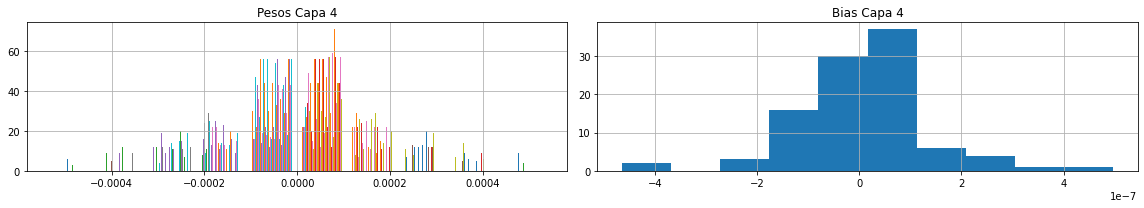

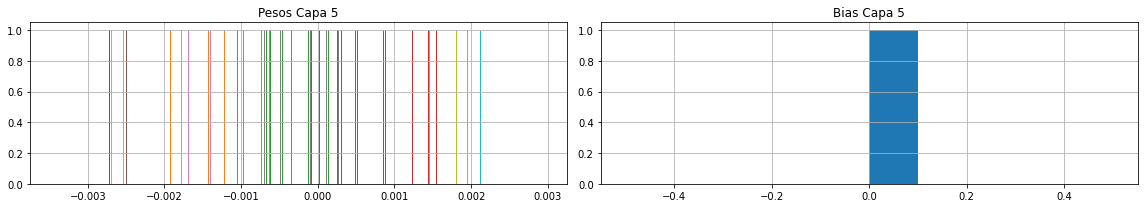

In [ ]:
plt.rcParams['figure.figsize'] = [16,3]
plt.suptitle('Histogramas de los pesos', size = 20, y = 1.2)
names = ['Pesos Capa 1', 'Bias Capa 1','Pesos Capa 2', 'Bias Capa 2','Pesos Capa 3', 'Bias Capa 3','Pesos Capa 4', 'Bias Capa 4','Pesos Capa 5', 'Bias Capa 5']
k = 1
for i in range(len(grad)):
  plt.subplot(1,2,k)
  plt.title(names[i])
  plt.hist(grad[i])
  plt.tight_layout()
  plt.grid()
  if k == 2:
    k = 1
    plt.show()
  else: 
    k += 1

In [ ]:
# Define arquitectura (2)
input_dense = input_layer.Input(shape=(8))
dense = layers.Dense(100, activation = 'relu', use_bias = True, kernel_initializer = 'uniform')(input_dense)
dense = layers.Dense(100, activation = 'relu', use_bias = True, kernel_initializer = 'uniform')(dense)
dense = layers.Dense(100, activation = 'relu', use_bias = True, kernel_initializer = 'uniform')(dense)
dense = layers.Dense(100, activation = 'relu', use_bias = True, kernel_initializer = 'uniform')(dense)
output_dense = layers.Dense(1, activation = 'relu', use_bias=True, kernel_initializer='uniform')(dense)
model = models.Model(inputs= input_dense, outputs = output_dense)

In [ ]:
# Get weights
weights1 = model.get_weights()
# Get gradient
with tf.GradientTape() as tape:
  y_pred = model(x_tr)
  loss   = tf.reduce_mean(tf.square(y_pred-y_tr))
  grad   = tape.gradient(loss, model.trainable_weights)

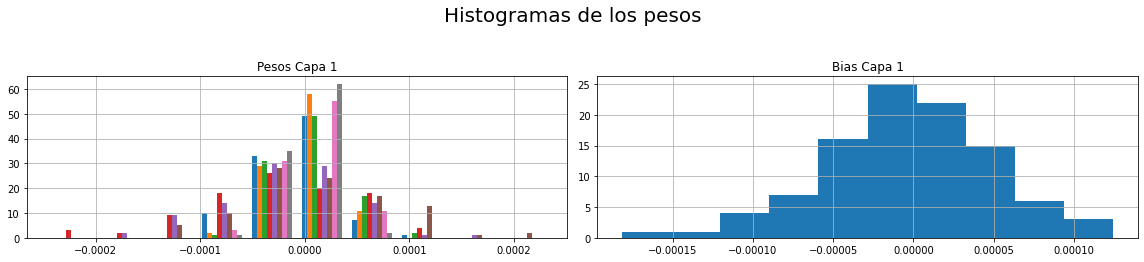

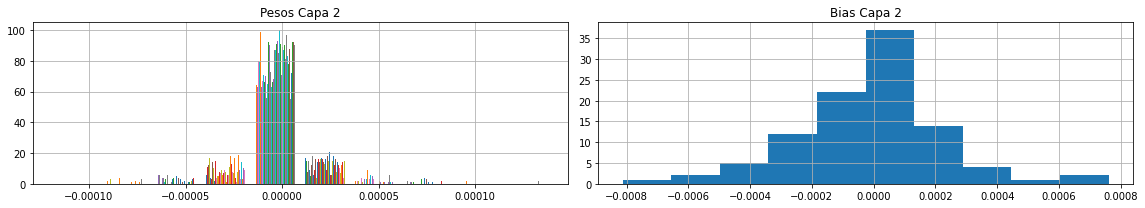

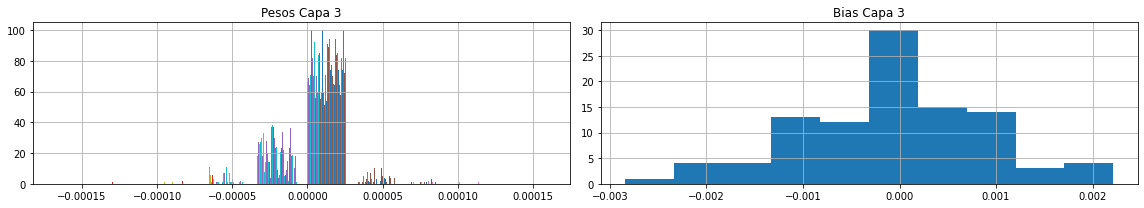

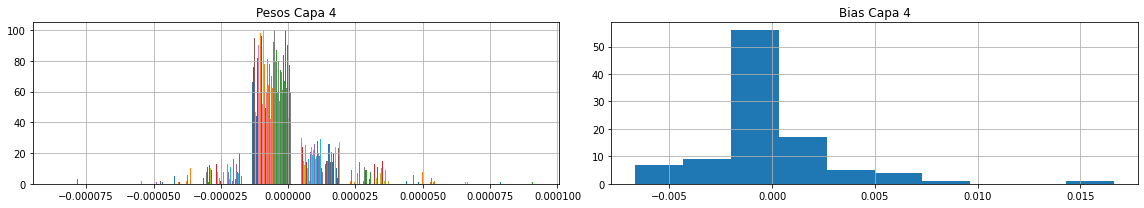

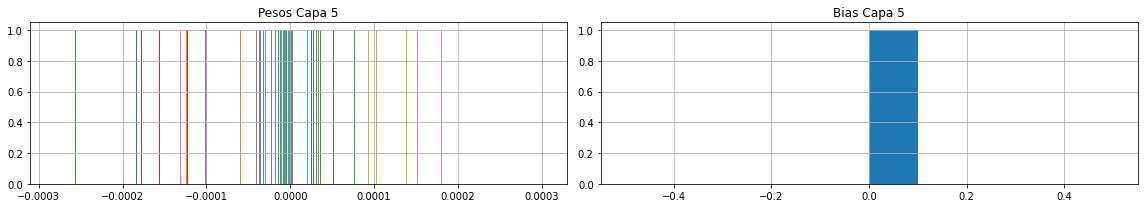

In [ ]:
plt.rcParams['figure.figsize'] = [16,3]
plt.suptitle('Histogramas de los pesos', size = 20, y = 1.2)
names = ['Pesos Capa 1', 'Bias Capa 1','Pesos Capa 2', 'Bias Capa 2','Pesos Capa 3', 'Bias Capa 3','Pesos Capa 4', 'Bias Capa 4','Pesos Capa 5', 'Bias Capa 5']
k = 1
for i in range(len(grad)):
  plt.subplot(1,2,k)
  plt.title(names[i])
  plt.hist(grad[i])
  plt.tight_layout()
  plt.grid()
  if k == 2:
    k = 1
    plt.show()
  else: 
    k += 1

**Comentarios:** los ejemplos anteriores se puede ver que los pesos fueron inicializados de forma uniforme, lo que se corrobora dado que para el rango de valores que puede tomar tiene la misma cantidad (de forma uniforme). Por otro lado, el gradiente se puede ver muy cercano al valor 0, esto debido a que como es una función de activación de este tipo se está trabajando en el rango óptimo.

## 1.d Regularización

i) Utilizando la siguiente arquitectura experimente con regularización L1 y L2 usando distintos valores de $\lambda$ para las distintas capas, pero manteniendo el mismo tipo de regularización en ambas capas ($L_1$ o $L_2$). **Entrene** 4 redes neuronales para cada norma con distintos valores de $\lambda$ en cada capa (8 redes en total). Utilice las variaciones de $\lambda$ que desee, puede usar las indicadas si desea. **Visualice y comente** los errores de entrenamiento, validación y la resta de ambos errores (e.d. error_tr - error_val).

**Pregunta:** ¿Cómo se comportarán los pesos de la red neuronal para la norma $L_1$ y para la norma $L_2$ en función de $\lambda$? Apoyarse en visualización de los pesos al final del entrenamiento para responder la pregunta.

In [ ]:
from keras.regularizers import l1, l2

# REGULARIZADOR L1
lambda_1st = [0,0.01]
lambda_2nd = [0,0.01]
rest_l1    = []
weights_l1 = []
for i in lambda_1st:
  for j in lambda_2nd:

    # Define architecture
    input_dense= input_layer.Input(shape=(8))
    dense=layers.Dense(500, activation='relu',activity_regularizer=l1(i),use_bias=True, kernel_initializer="glorot_normal")(input_dense)
    dense=layers.Dense(500, activation='relu',activity_regularizer=l1(j),use_bias=True, kernel_initializer="glorot_normal")(input_dense)
    output_dense=layers.Dense(1, activation='relu',use_bias=True, kernel_initializer="uniform")(dense)
    model=models.Model(inputs=input_dense, outputs=output_dense)
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
    # Train model
    hist = model.fit(x_tr, y_tr, epochs=200, verbose=0, validation_data=(x_val, y_val),callbacks=[History()])

    rest_l1.append([i,j,hist.history['loss'],hist.history['val_loss']])
    weights_l1.append(model.get_weights())

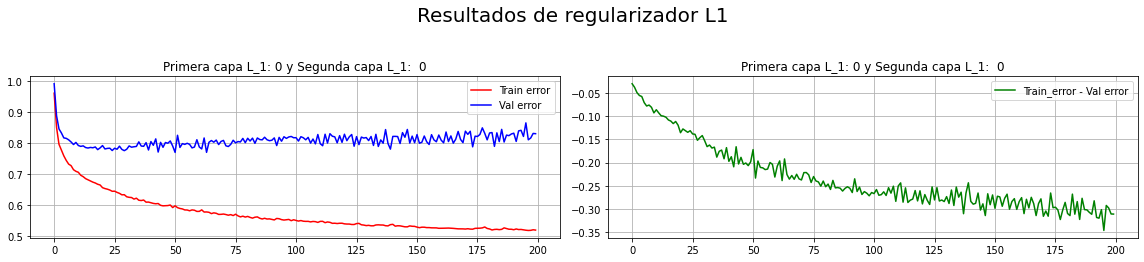

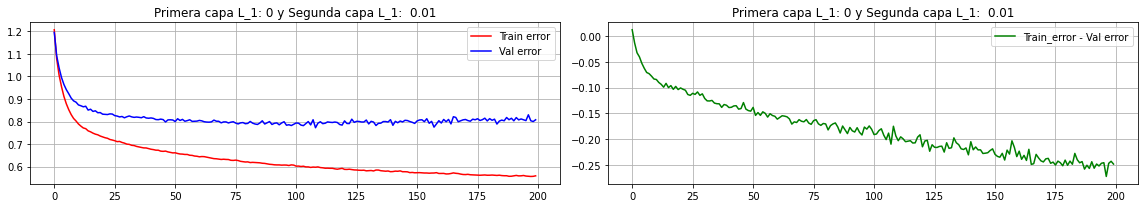

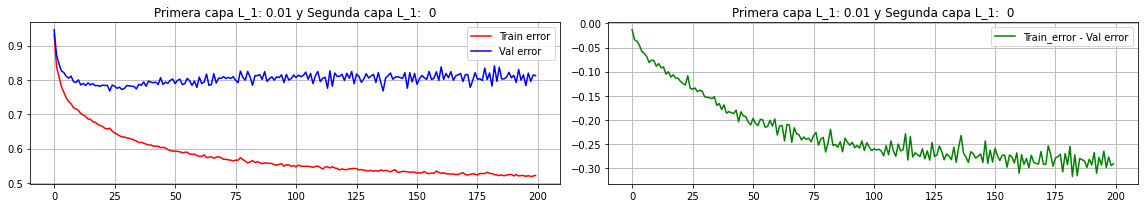

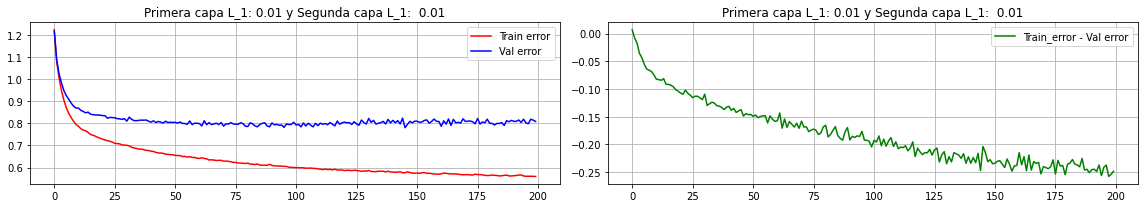

In [ ]:
plt.rcParams['figure.figsize']=[16,3]
plt.suptitle('Resultados de regularizador L1',size=20,y=1.2)

k=1
for i in range(len(rest_l1)):
  plt.subplot(1,2,k)
  plt.title('Primera capa L_1: '+str(rest_l1[i][0])+' y Segunda capa L_1:  '+str(rest_l1[i][1]))
  plt.plot(rest_l1[i][2],"r", label = 'Train error')
  plt.plot(rest_l1[i][3],"b", label = 'Val error')
  plt.tight_layout()
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Primera capa L_1: '+str(rest_l1[i][0])+' y Segunda capa L_1:  '+str(rest_l1[i][1]))
  plt.plot(np.asarray(rest_l1[i][2])-np.asarray(rest_l1[i][3]),"g",label = 'Train_error - Val error')
  plt.tight_layout()
  plt.grid()
  plt.legend()
  if k==1:
    k=1
    plt.show()

**Comentarios:** en este gráfico se aprecia que aplicar regularización a la segunda capa condiciona el entrenamiento de mayor forma que para el caso cuando a la primera capa se le aplica regularización. Al aplicar regularización L1, se puede ver que el error entre el error de validación y el de train disminuye. Es más, en el caso que se le aplica un regularizador L1 a la segunda capa, la diferencia entre los errores disminuye más.

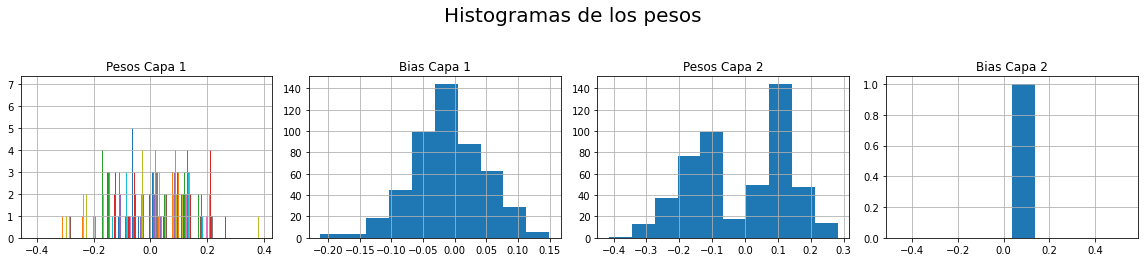

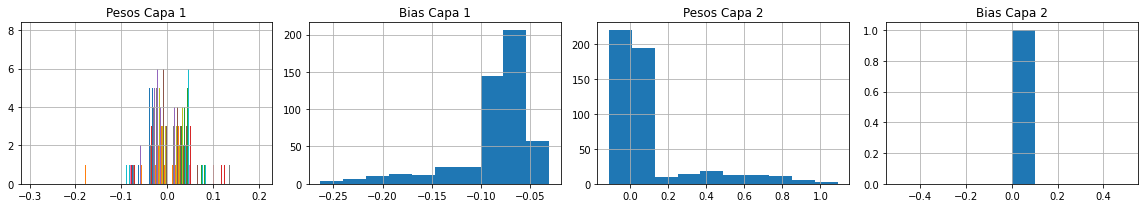

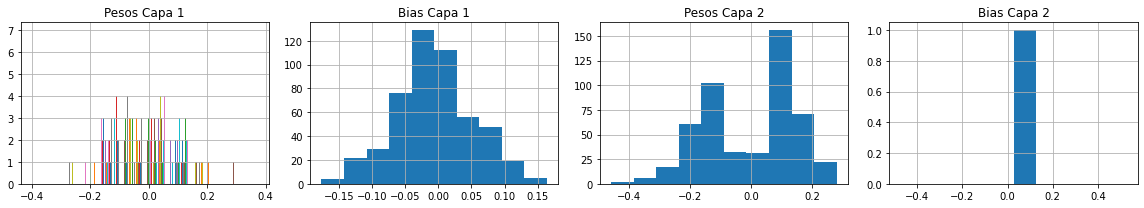

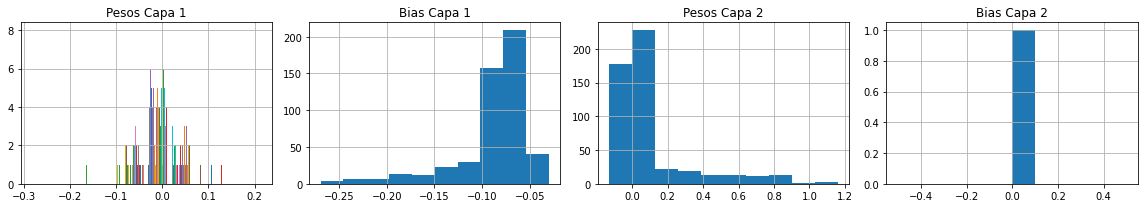

In [ ]:
# VISUALIZAR LOS PESOS FINALES
plt.rcParams['figure.figsize'] = [16,3]
plt.suptitle('Histogramas de los pesos', size = 20, y = 1.2)
names = ['Pesos Capa 1', 'Bias Capa 1','Pesos Capa 2', 'Bias Capa 2','Pesos Capa 3', 'Bias Capa 3','Pesos Capa 4', 'Bias Capa 4']
k = 1
for i in range(len(weights_l1)):
  for j in range(len(weights_l1[i])):
    plt.subplot(1,4,k)
    plt.title(names[j])
    plt.hist(weights_l1[i][j])
    plt.tight_layout()
    plt.grid()
    if k == 4:
      k = 1
      plt.show()
    else: 
      k += 1

**Comentarios:** el gráfico de los pesos antes y despues de la regularización demuestra los comentarios anteriores, donde se ve que al aplicar regularización L1 a la arquitectura los pesos se ven afectos disminuyendo la cantidad de pesos distintos de 0. 

In [ ]:
# REGULARIZADOR L2
lambda_1st = [50,0.01]
lambda_2nd = [50,0.01]
rest_l2    = []
weights_l2 = []

for i in lambda_1st:
  for j in lambda_2nd:

    # Define architecture
    input_dense= input_layer.Input(shape=(8))
    dense=layers.Dense(500, activation='relu',activity_regularizer=l2(i),use_bias=True, kernel_initializer="glorot_normal")(input_dense)
    dense=layers.Dense(500, activation='relu',activity_regularizer=l2(j),use_bias=True, kernel_initializer="glorot_normal")(input_dense)
    output_dense=layers.Dense(1, activation='relu',use_bias=True, kernel_initializer="uniform")(dense)
    model=models.Model(inputs=input_dense, outputs=output_dense)
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
    # Train model
    hist = model.fit(x_tr, y_tr, epochs=200, verbose=0, validation_data=(x_val, y_val),callbacks=[History()])

    rest_l2.append([i,j,hist.history['loss'],hist.history['val_loss']])
    weights_l2.append(model.get_weights())

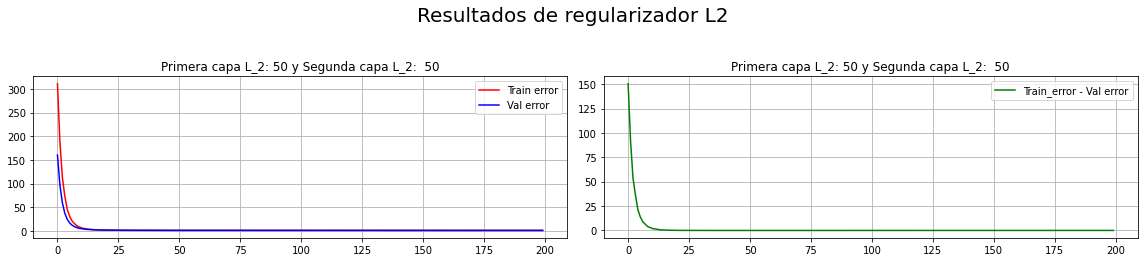

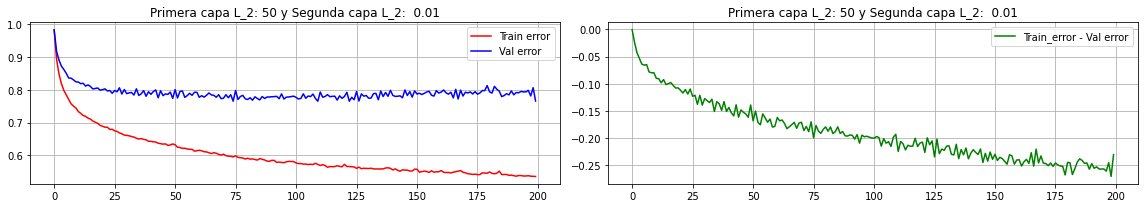

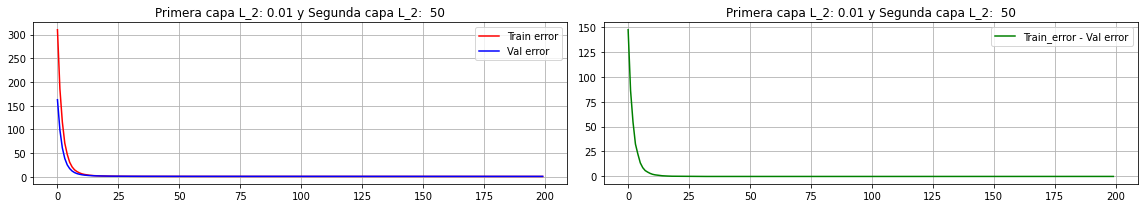

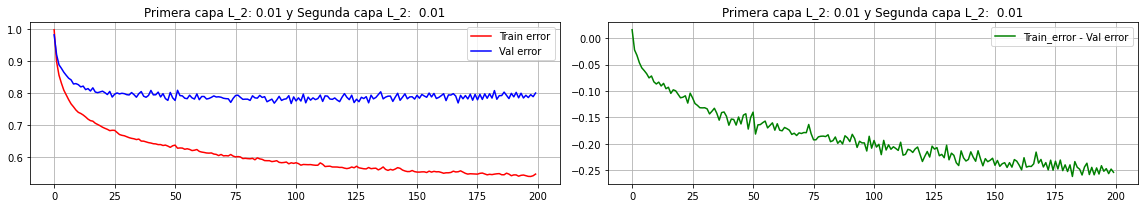

In [ ]:
plt.rcParams['figure.figsize']=[16,3]
plt.suptitle('Resultados de regularizador L2',size=20,y=1.2)

k=1
for i in range(len(rest_l2)):
  plt.subplot(1,2,k)
  plt.title('Primera capa L_2: '+str(rest_l2[i][0])+' y Segunda capa L_2:  '+str(rest_l2[i][1]))
  plt.plot(rest_l2[i][2],"r", label = 'Train error')
  plt.plot(rest_l2[i][3],"b", label = 'Val error')
  plt.tight_layout()
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Primera capa L_2: '+str(rest_l2[i][0])+' y Segunda capa L_2:  '+str(rest_l2[i][1]))
  plt.plot(np.asarray(rest_l2[i][2])-np.asarray(rest_l2[i][3]),"g",label = 'Train_error - Val error')
  plt.tight_layout()
  plt.grid()
  plt.legend()
  if k==1:
    k=1
    plt.show()

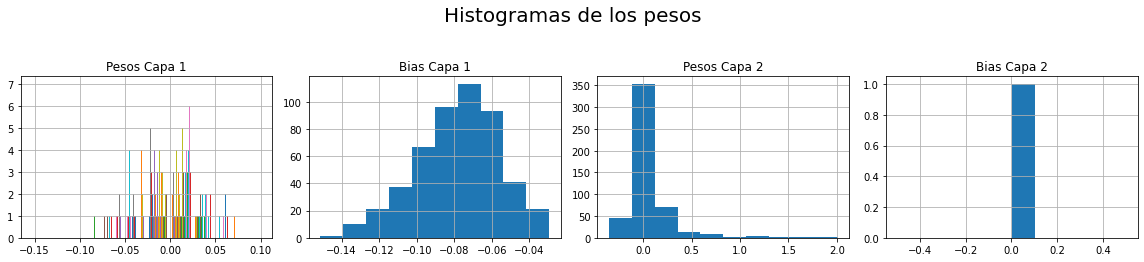

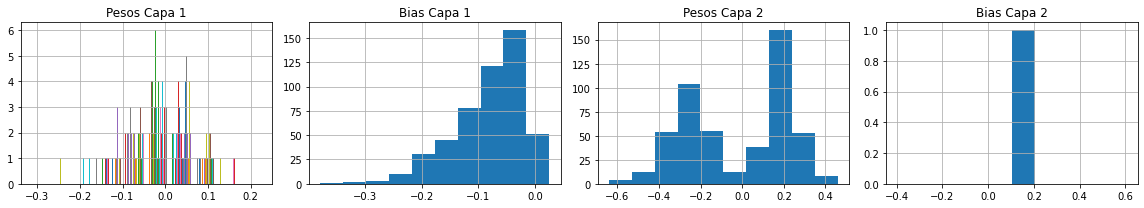

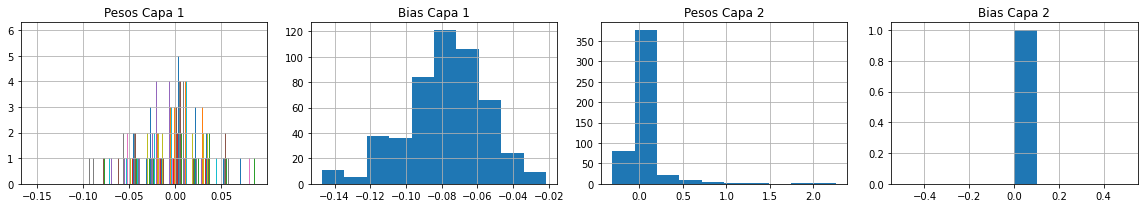

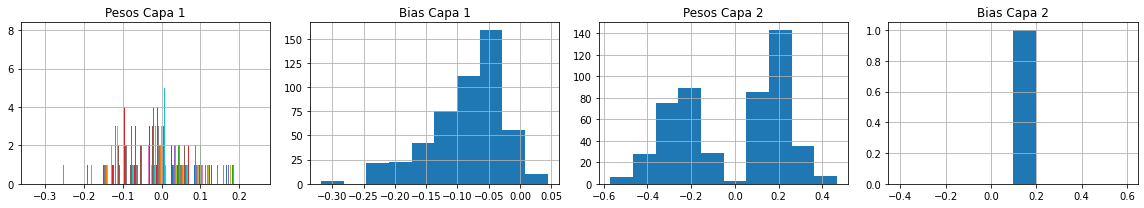

In [ ]:
# VISUALIZAR LOS PESOS FINALES
plt.rcParams['figure.figsize'] = [16,3]
plt.suptitle('Histogramas de los pesos', size = 20, y = 1.2)
names = ['Pesos Capa 1', 'Bias Capa 1','Pesos Capa 2', 'Bias Capa 2','Pesos Capa 3', 'Bias Capa 3','Pesos Capa 4', 'Bias Capa 4']
k = 1
for i in range(len(weights_l2)):
  for j in range(len(weights_l2[i])):
    plt.subplot(1,4,k)
    plt.title(names[j])
    plt.hist(weights_l2[i][j])
    plt.tight_layout()
    plt.grid()
    if k == 4:
      k = 1
      plt.show()
    else: 
      k += 1

**Comentarios:** las conclusiones con los regularizadores para este problema son similares, dado que para ambos casos el regularizor funciona mejor al ser aplicado en la segunda capa. Además, es necesario mencionar que el $\lambda$ a utilizar varia en ordenes de magnitud entre regularizadores. De los pesos se puede concluir algo similar, la gran diferencia está en que para el caso de L1, se disminuye considerablemente la cantidad de pesos distintos de cero.

II) Experimentaremos con el método dropout. Probaremos con distintos valores de Dropout para ambas capas de la arquitectura presentada, de manera similar al punto anterior. Entrene 9 redes neuronales utilizando las combinaciones indicadas. **Visualizar, comparar y comentar** utilizando los errores de entrenamiento, validación y la resta entre ambos valores.

**Pregunta:** ¿Qué es/hace dropout?¿Por qué es considerado un método de regularización?

**Respuesta:** dropout lo que hace es multiplicar la capa de salida de una determinada capa por un vector r, el cual corresponde a un vector de variables aleatorias de distribución bernoulli donde cada entrada del vector tiene una probabilidad _p_ de ser 1. De esta forma, existiran unidades que se anulen y solo queden activadas las son multiplicadas por uno. Esta técnica es implementada para solucionar el problema de overfitting dado que en una red profunda tiene muchos parámetros y combina los resultados de todas las neuronas.Se considera un método de regularización ya que al anular aleatoriamente unidades, esta metodología permite reducir la complejidad del modelo, por ende se disminuye las chances de overfitting.

In [ ]:
dropout_1st = [0,0.3,0.6]
dropout_2nd = [0,0.3,0.6]
rest_drop   = []

for i in dropout_1st:
  for j in dropout_2nd:

    # Define arquitectura
    input_dense = input_layer.Input(shape = (8))
    dense   = layers.Dense(500, activation='relu',use_bias=True, kernel_initializer="glorot_normal")(input_dense)
    dense   = layers.Dropout(i)(dense)
    dense=layers.Dense(500, activation='relu',use_bias=True, kernel_initializer="glorot_normal")(dense)
    dense=layers.Dropout(j)(dense)
    output_dense=layers.Dense(1, activation='relu',use_bias=True, kernel_initializer="uniform")(dense)
    model=models.Model(inputs=input_dense, outputs=output_dense)

    # Compilar model
    model.compile(optimizer=Adam(learning_rate=0.01), loss ='mean_squared_error')
    # train model
    hist = model.fit(x_tr,y_tr, epochs=200, verbose = 0, 
                     validation_data=(x_val,y_val), callbacks = [History()])
    
    rest_drop.append([i,j,hist.history['loss'],hist.history['val_loss']])

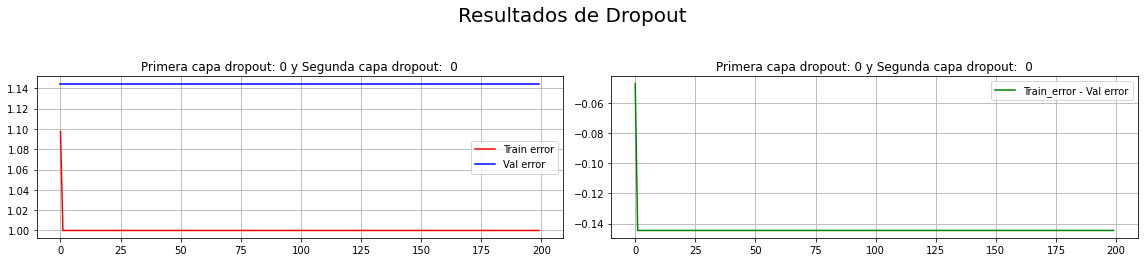

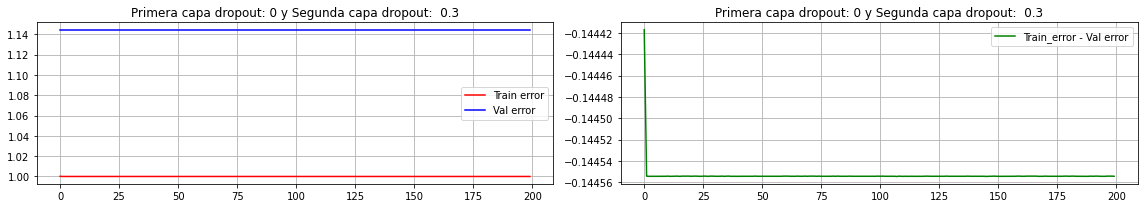

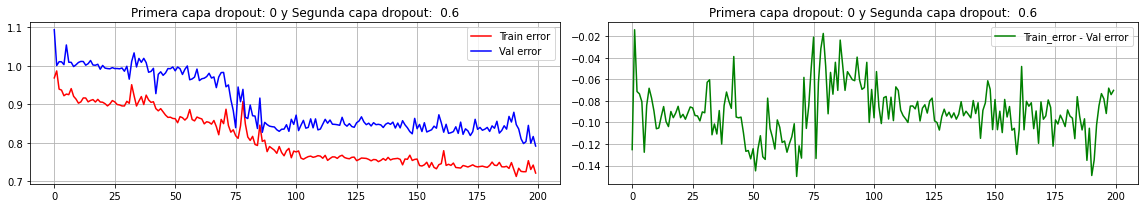

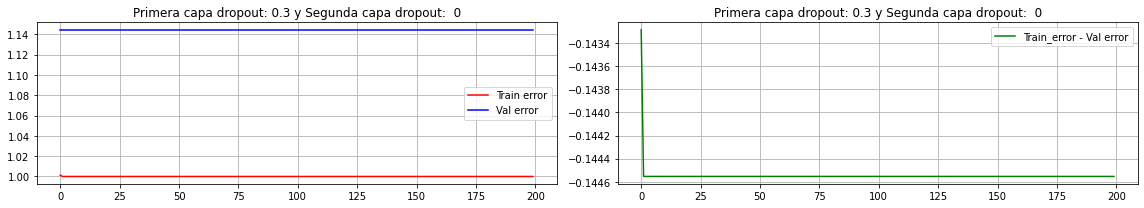

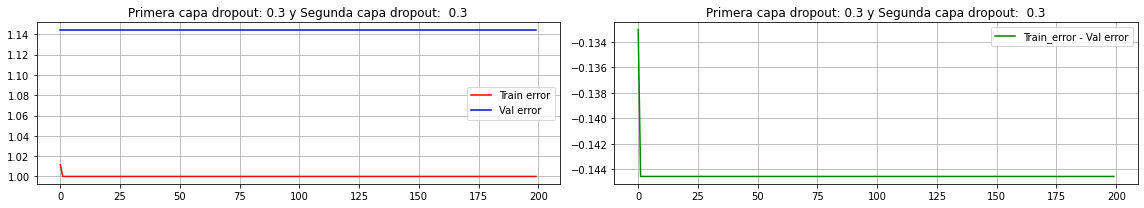

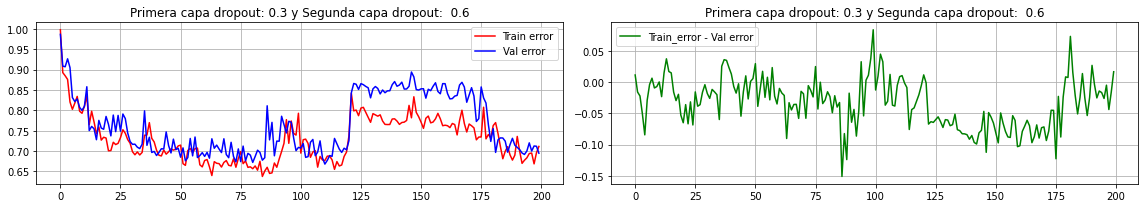

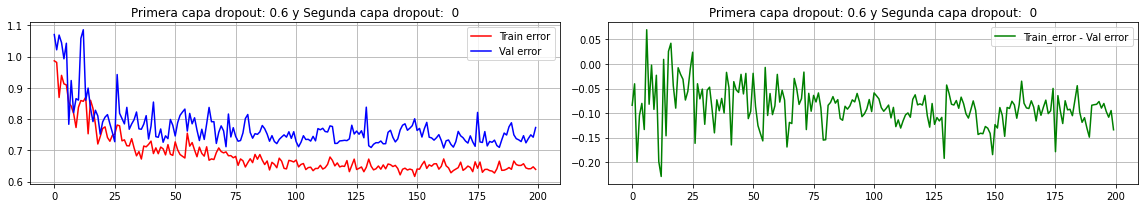

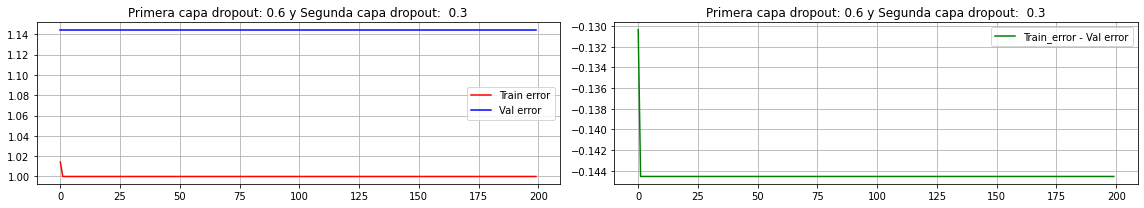

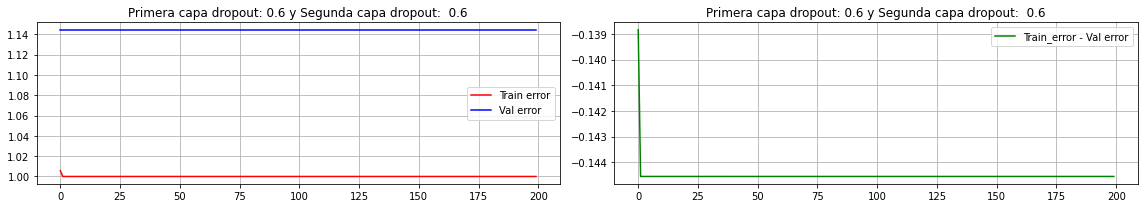

In [ ]:
plt.rcParams['figure.figsize']=[16,3]
plt.suptitle('Resultados de Dropout',size=20,y=1.2)

k=1
for i in range(len(rest_drop)):
  plt.subplot(1,2,k)
  plt.title('Primera capa dropout: '+str(rest_drop[i][0])+' y Segunda capa dropout:  '+str(rest_drop[i][1]))
  plt.plot(rest_drop[i][2],"r", label = 'Train error')
  plt.plot(rest_drop[i][3],"b", label = 'Val error')
  plt.tight_layout()
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Primera capa dropout: '+str(rest_drop[i][0])+' y Segunda capa dropout:  '+str(rest_drop[i][1]))
  plt.plot(np.asarray(rest_drop[i][2])-np.asarray(rest_drop[i][3]),"g",label = 'Train_error - Val error')
  plt.tight_layout()
  plt.grid()
  plt.legend()
  if k==1:
    k=1
    plt.show()

**Comentarios:** una gran conclusión de los gráficos anteriores es que el menor error se da para el caso donde se le aplica dropout de 0.3 y 0.6 a la primera y segunda capa respectivamente. Nuevamente se puede concluir que aplicar alguna técnica de regularización ayuda en el entrenamiento de la red, más aún, si se aplica a la segunda capa.

## 1.e Extreme Learning Machines

I) Una aproximación para obtener modelos grandes que no sobreajustan es la implementada por ELM. Explique en qué consiste la idea de ELM y por qué esto podria evitar sobreajuste a pesar de utilizar modelos con gran número de parámetros. 

Entrene una ELM de una capa fija y una capa oculta, la primera con un número relativamente grande. Puede utilizar los valores propuestos en el códigos u otros que le parezcan convenientes. 

Comente sobre el número total de parámetros y el número de parámetros entrenables con respecto a los modelos anteriores.

**Preguntas:** ¿Cómo se desempeña la red?¿El número elevado de parámetros totales implica necesariamente _overfitting_?

ELM son redes neuronales de retroalimentación con capas ocultas que tienen parámetros no entrenables. Por lo tanto, su gran ventaja es porque la cantidad de parámetros del modelo reduce considerablemente lo que permite un entrenamiento más rápido del modelo.


In [ ]:
# Arquitectura Extreme Learning Machine

input_dense  = input_layer.Input(shape=(x_tr.shape[1]))
dense        = layers.Dense(5000, activation = 'sigmoid', use_bias = True, trainable=False)(input_dense)
dense        = layers.Dense(100, activation = 'sigmoid', use_bias = True)(dense)
output_dense = layers.Dense(1, activation = 'sigmoid', use_bias = True)(dense)
model        = models.Model(inputs = input_dense, outputs = output_dense)

# Compilación
model.compile(optimizer=SGD(learning_rate=0.001), loss = 'mean_squared_error')
my_callbacks = [History(),
                tf.keras.callbacks.EarlyStopping(patience = 500, 
                                                 monitor = 'val_loss', restore_best_weights = True)]                                   
hist_1_e = model.fit(x_tr,y_tr, epochs = 500, verbose = 0, 
                       validation_data = (x_val,y_val), callbacks = my_callbacks)
y_pred1 = model.predict(x_tst)
test_batch_loss1 = tf.keras.losses.MSE(y_tst,y_pred1)

In [ ]:
# Arquitectura

input_dense  = input_layer.Input(shape=(x_tr.shape[1]))
dense        = layers.Dense(100, activation = 'sigmoid', use_bias = True)(input_dense)
output_dense = layers.Dense(1, activation = 'sigmoid', use_bias = True)(dense)
model        = models.Model(inputs = input_dense, outputs = output_dense)

# Compilación
model.compile(optimizer=SGD(learning_rate=0.01), loss = 'mean_squared_error')

# Callbacks
my_callbacks = [History(),
                tf.keras.callbacks.EarlyStopping(patience = 500, 
                                                 monitor = 'val_loss', restore_best_weights = True)]    

# Train model
hist_1_b_i = model.fit(x_tr,y_tr, epochs = 500, verbose = 0, 
                       validation_data = (x_val,y_val), callbacks = my_callbacks)    

y_pred = model.predict(x_tst)
test_batch_loss = tf.keras.losses.MSE(y_tst,y_pred)

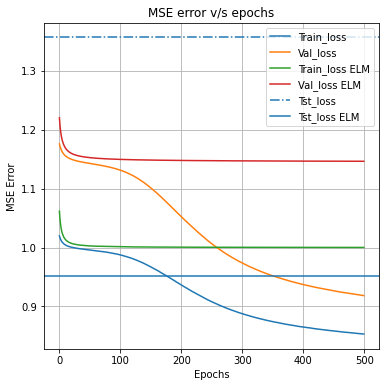

In [ ]:
plt.rcParams['figure.figsize'] = [6,6]
test_loss_1_e = tf.math.reduce_mean(test_batch_loss1).numpy()    
test_loss_1_b = tf.math.reduce_mean(test_batch_loss).numpy()                  # Calcula el promedio de test_batch_loss
plt.title('MSE error v/s epochs')
plt.plot(hist_1_b_i.history['loss'],label = 'Train_loss')
plt.plot(hist_1_b_i.history['val_loss'],label = 'Val_loss')
plt.plot(hist_1_e.history['loss'],label = 'Train_loss ELM')
plt.plot(hist_1_e.history['val_loss'],label = 'Val_loss ELM')
plt.axhline(y = test_loss_1_e, linestyle = '-.', label = 'Tst_loss')
plt.axhline(y = test_loss_1_b, linestyle = '-', label = 'Tst_loss ELM')
plt.xlabel('Epochs'),plt.ylabel('MSE Error')
plt.legend(),plt.grid()
plt.show()

In [ ]:
model.summary()

Model: "functional_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_256 (Dense)            (None, 5000)              45000     
_________________________________________________________________
dense_257 (Dense)            (None, 500)               2500500   
_________________________________________________________________
dense_258 (Dense)            (None, 1)                 501       
Total params: 2,546,001
Trainable params: 2,501,001
Non-trainable params: 45,000
_________________________________________________________________


**Comentarios:** Se puede ver que ELM si bien utiliza una menor cantidad de parámetros para entrenar, los resultados no son mejores que para el caso de la red entrenando todos sus parámetros. Al no entrenar la primera capa, la red tiene menos espacio para encontrar una hipótesis correcta, pero existen casos donde se pueda aplicar este tipo de red o con más cantidad de datos se pueden obtener mejores resultados.